In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value.cpu().detach()
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value.cpu().detach()
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value.cpu().detach()
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def recognition_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return init_bouncing_ball, bouncing_ball_step

In [17]:
def attach_proposals(model, num_particles):
    init_proposal, step_proposal = recognition_model(num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: importance.Propose(m, init_proposal)
    model = model.apply(init_attach, init_selector)

    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: importance.Propose(m, step_proposal)
    return model.apply(step_attach, step_selector)

In [18]:
def training_model(num_particles, inference_strategy):
    model = generative_model(num_particles)
    model = attach_proposals(model, num_particles)
    return inference_strategy(model)

In [19]:
trajectory, displacements, data = generate_trajectory_trace()

In [20]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True, log_estimator=False):
    sampler = training_model(num_particles, inference_strategy)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 500, data, use_cuda=True, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
        log_estimator=log_estimator,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [21]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [22]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Monte Carlo importance sampling', 'Importance Weighted sampling', 'Sequential Monte Carlo']
sampling_strategies = [(lambda m: m, False), (lambda m: m, True), (lambda m: importance.smc(m), False)]
kl_directions = [False, True]

In [23]:
def experiment():
    results = {}
    for i, (inference_strategy, estimator) in enumerate(sampling_strategies):
        for inclusive_kl in kl_directions:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True, log_estimator=estimator)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, inclusive_kl)] = (tau, evidence_bounds)
    return results

03/04/2019 13:35:25 Experimenting with sampling strategy: Monte Carlo importance sampling
03/04/2019 13:35:25 Experimenting with sample size of 2
03/04/2019 13:35:25 Experimenting with Variational training
03/04/2019 13:35:26 ELBO=-2.92947021e+03 at epoch 1
03/04/2019 13:35:27 ELBO=-1.61732581e+03 at epoch 2
03/04/2019 13:35:27 ELBO=-6.58278320e+02 at epoch 3
03/04/2019 13:35:27 ELBO=-5.85493896e+02 at epoch 4
03/04/2019 13:35:27 ELBO=-4.55101044e+02 at epoch 5
03/04/2019 13:35:27 ELBO=-4.37821625e+02 at epoch 6
03/04/2019 13:35:28 ELBO=-7.32116272e+02 at epoch 7
03/04/2019 13:35:28 ELBO=-8.94689087e+02 at epoch 8
03/04/2019 13:35:28 ELBO=-1.50370398e+03 at epoch 9
03/04/2019 13:35:28 ELBO=-6.33425964e+02 at epoch 10
03/04/2019 13:35:28 ELBO=-4.33630981e+02 at epoch 11
03/04/2019 13:35:28 ELBO=-4.78812866e+02 at epoch 12
03/04/2019 13:35:29 ELBO=-4.66947815e+02 at epoch 13
03/04/2019 13:35:29 ELBO=-5.16294556e+02 at epoch 14
03/04/2019 13:35:29 ELBO=-5.15329163e+02 at epoch 15
03/04/20

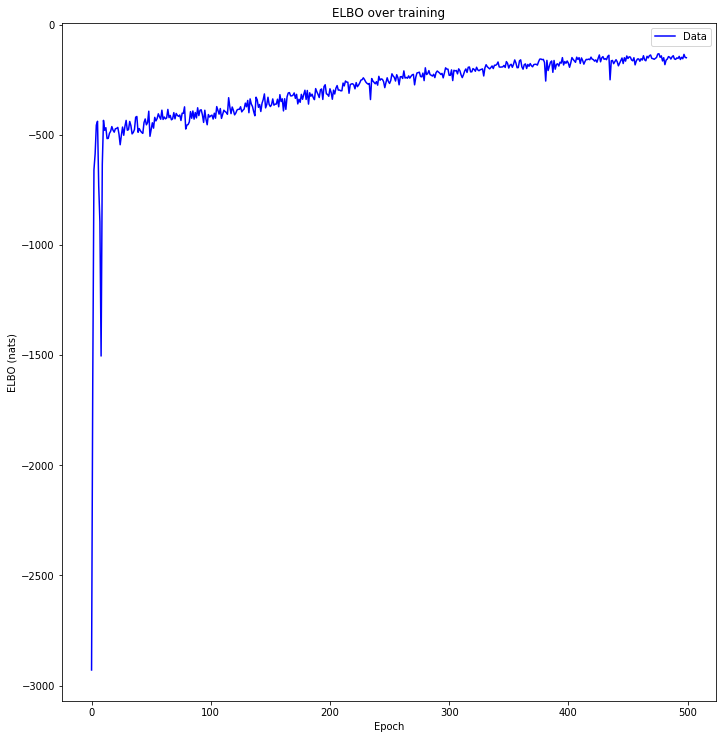

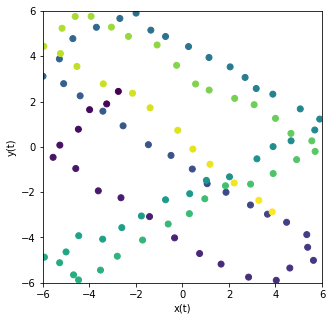

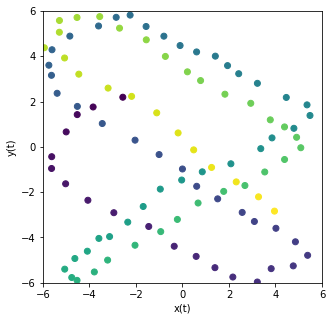

03/04/2019 13:37:00 MSE at time 0: tensor(0.1032)
03/04/2019 13:37:00 MSE at time 1: tensor(0.3586)
03/04/2019 13:37:00 MSE at time 2: tensor(0.3304)
03/04/2019 13:37:00 MSE at time 3: tensor(0.2890)
03/04/2019 13:37:00 MSE at time 4: tensor(0.3822)
03/04/2019 13:37:00 MSE at time 5: tensor(0.2476)
03/04/2019 13:37:00 MSE at time 6: tensor(0.6450)
03/04/2019 13:37:00 MSE at time 7: tensor(0.3744)
03/04/2019 13:37:00 MSE at time 8: tensor(0.5309)
03/04/2019 13:37:00 MSE at time 9: tensor(0.1917)
03/04/2019 13:37:00 MSE at time 10: tensor(0.1372)
03/04/2019 13:37:00 MSE at time 11: tensor(0.0379)
03/04/2019 13:37:00 MSE at time 12: tensor(0.0943)
03/04/2019 13:37:00 MSE at time 13: tensor(0.4589)
03/04/2019 13:37:00 MSE at time 14: tensor(0.6693)
03/04/2019 13:37:00 MSE at time 15: tensor(0.6429)
03/04/2019 13:37:00 MSE at time 16: tensor(0.8130)
03/04/2019 13:37:00 MSE at time 17: tensor(0.1260)
03/04/2019 13:37:00 MSE at time 18: tensor(0.3399)
03/04/2019 13:37:00 MSE at time 19: tenso

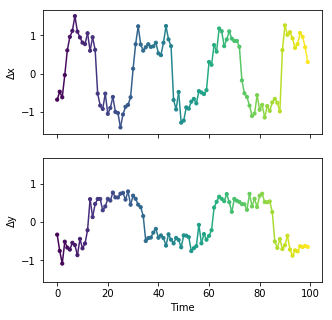

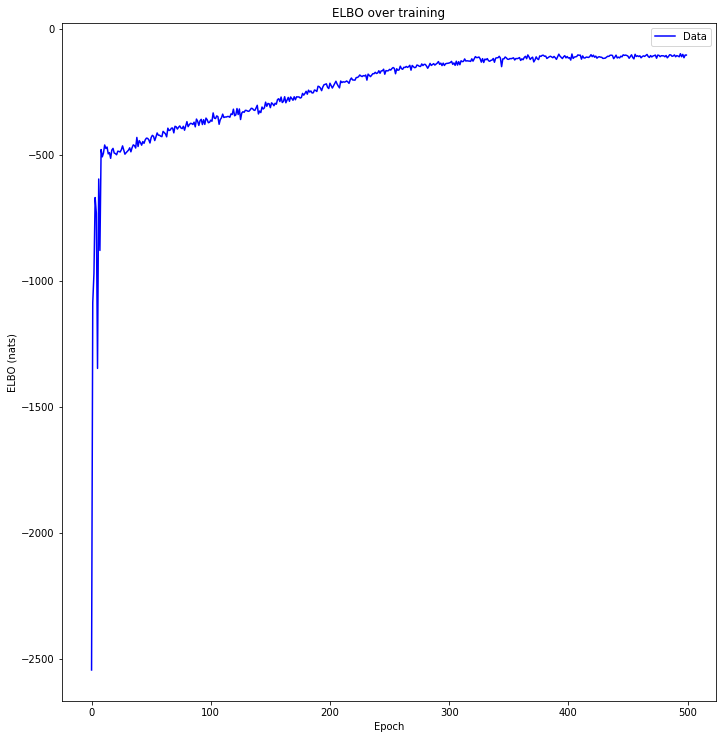

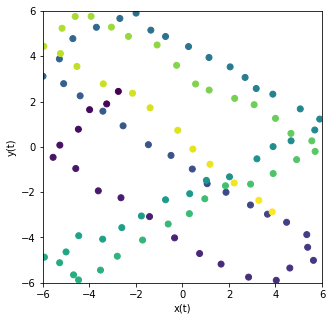

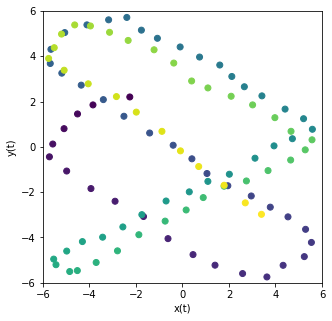

03/04/2019 13:38:30 MSE at time 0: tensor(0.3027)
03/04/2019 13:38:30 MSE at time 1: tensor(0.3497)
03/04/2019 13:38:30 MSE at time 2: tensor(0.3052)
03/04/2019 13:38:30 MSE at time 3: tensor(0.3801)
03/04/2019 13:38:30 MSE at time 4: tensor(0.0951)
03/04/2019 13:38:30 MSE at time 5: tensor(0.0256)
03/04/2019 13:38:30 MSE at time 6: tensor(0.1658)
03/04/2019 13:38:30 MSE at time 7: tensor(0.1098)
03/04/2019 13:38:30 MSE at time 8: tensor(0.0885)
03/04/2019 13:38:30 MSE at time 9: tensor(0.0668)
03/04/2019 13:38:30 MSE at time 10: tensor(0.0812)
03/04/2019 13:38:30 MSE at time 11: tensor(0.0820)
03/04/2019 13:38:30 MSE at time 12: tensor(0.0700)
03/04/2019 13:38:30 MSE at time 13: tensor(0.0914)
03/04/2019 13:38:30 MSE at time 14: tensor(0.1841)
03/04/2019 13:38:30 MSE at time 15: tensor(0.0972)
03/04/2019 13:38:30 MSE at time 16: tensor(0.1813)
03/04/2019 13:38:30 MSE at time 17: tensor(0.0718)
03/04/2019 13:38:30 MSE at time 18: tensor(0.0572)
03/04/2019 13:38:30 MSE at time 19: tenso

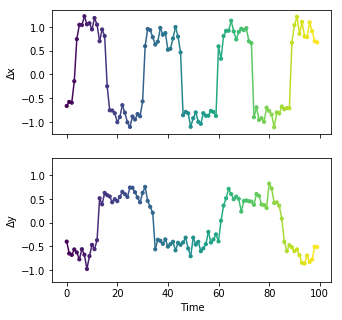

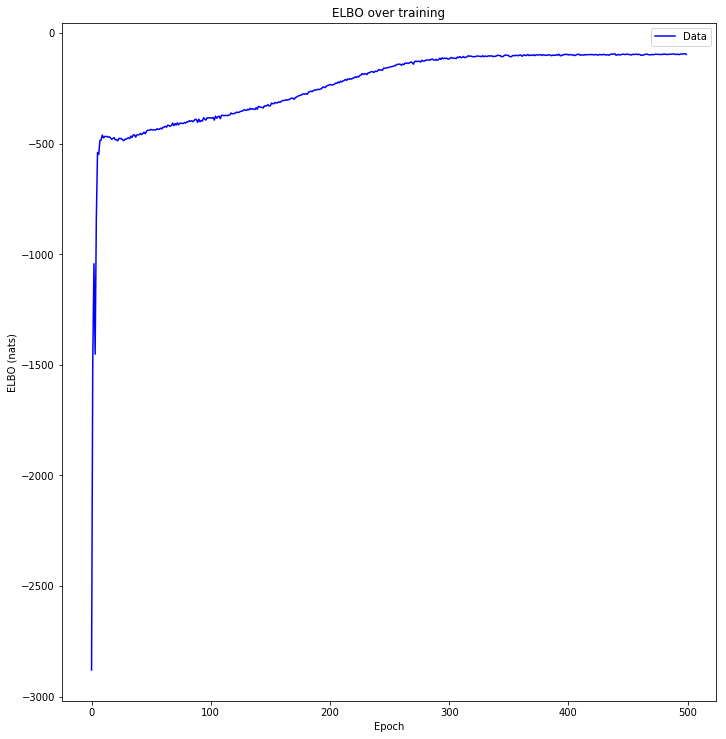

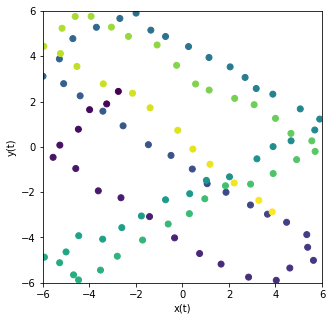

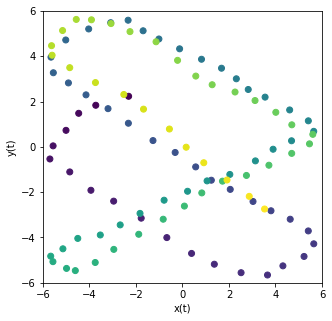

03/04/2019 13:40:11 MSE at time 0: tensor(0.2418)
03/04/2019 13:40:11 MSE at time 1: tensor(0.2239)
03/04/2019 13:40:11 MSE at time 2: tensor(0.2456)
03/04/2019 13:40:11 MSE at time 3: tensor(0.2852)
03/04/2019 13:40:11 MSE at time 4: tensor(0.0850)
03/04/2019 13:40:11 MSE at time 5: tensor(0.0245)
03/04/2019 13:40:11 MSE at time 6: tensor(0.0895)
03/04/2019 13:40:11 MSE at time 7: tensor(0.1015)
03/04/2019 13:40:11 MSE at time 8: tensor(0.1218)
03/04/2019 13:40:11 MSE at time 9: tensor(0.1334)
03/04/2019 13:40:11 MSE at time 10: tensor(0.1114)
03/04/2019 13:40:11 MSE at time 11: tensor(0.1195)
03/04/2019 13:40:11 MSE at time 12: tensor(0.0842)
03/04/2019 13:40:11 MSE at time 13: tensor(0.1425)
03/04/2019 13:40:11 MSE at time 14: tensor(0.1968)
03/04/2019 13:40:11 MSE at time 15: tensor(0.0974)
03/04/2019 13:40:11 MSE at time 16: tensor(0.1929)
03/04/2019 13:40:11 MSE at time 17: tensor(0.0926)
03/04/2019 13:40:11 MSE at time 18: tensor(0.0306)
03/04/2019 13:40:11 MSE at time 19: tenso

Epoch   350: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:41:16 EUBO=1.60142517e+02 at epoch 353
03/04/2019 13:41:16 EUBO=1.51174240e+02 at epoch 354
03/04/2019 13:41:16 EUBO=1.64423325e+02 at epoch 355
03/04/2019 13:41:16 EUBO=1.37150391e+02 at epoch 356
03/04/2019 13:41:16 EUBO=1.60449921e+02 at epoch 357
03/04/2019 13:41:17 EUBO=1.38387268e+02 at epoch 358
03/04/2019 13:41:17 EUBO=1.23660934e+02 at epoch 359
03/04/2019 13:41:17 EUBO=1.48115555e+02 at epoch 360
03/04/2019 13:41:17 EUBO=1.31656067e+02 at epoch 361
03/04/2019 13:41:17 EUBO=1.31832245e+02 at epoch 362
03/04/2019 13:41:18 EUBO=1.66608932e+02 at epoch 363
03/04/2019 13:41:18 EUBO=1.47104141e+02 at epoch 364
03/04/2019 13:41:18 EUBO=1.17377251e+02 at epoch 365
03/04/2019 13:41:18 EUBO=1.30260315e+02 at epoch 366
03/04/2019 13:41:18 EUBO=1.35682068e+02 at epoch 367
03/04/2019 13:41:18 EUBO=1.54395081e+02 at epoch 368
03/04/2019 13:41:19 EUBO=1.31581940e+02 at epoch 369
03/04/2019 13:41:19 EUBO=1.47407837e+02 at epoch 370
03/04/2019 13:41:19 EUBO=1.27170212e+02 at epo

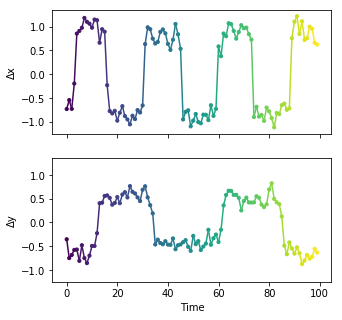

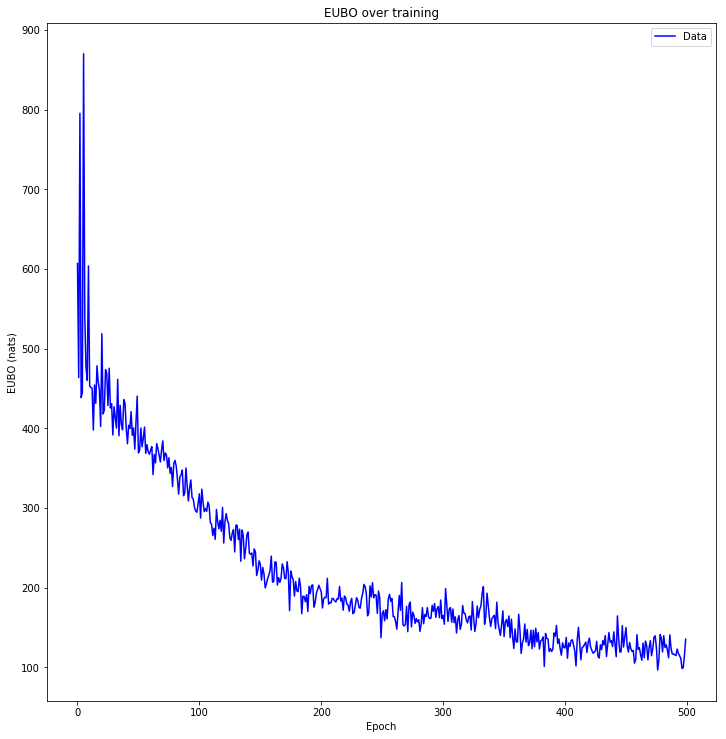

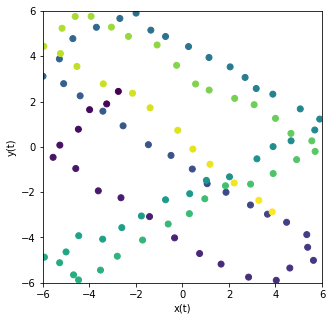

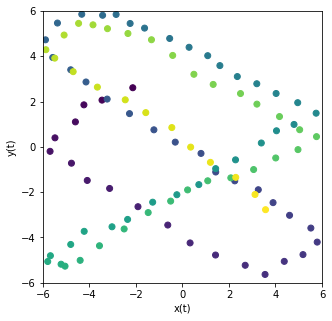

03/04/2019 13:41:44 MSE at time 0: tensor(0.4105)
03/04/2019 13:41:44 MSE at time 1: tensor(0.0683)
03/04/2019 13:41:44 MSE at time 2: tensor(0.1054)
03/04/2019 13:41:44 MSE at time 3: tensor(0.1211)
03/04/2019 13:41:44 MSE at time 4: tensor(0.1475)
03/04/2019 13:41:44 MSE at time 5: tensor(0.0867)
03/04/2019 13:41:44 MSE at time 6: tensor(0.0896)
03/04/2019 13:41:44 MSE at time 7: tensor(0.4357)
03/04/2019 13:41:44 MSE at time 8: tensor(0.4065)
03/04/2019 13:41:44 MSE at time 9: tensor(0.4388)
03/04/2019 13:41:44 MSE at time 10: tensor(0.4061)
03/04/2019 13:41:44 MSE at time 11: tensor(0.3860)
03/04/2019 13:41:44 MSE at time 12: tensor(0.2168)
03/04/2019 13:41:44 MSE at time 13: tensor(0.2948)
03/04/2019 13:41:44 MSE at time 14: tensor(0.2993)
03/04/2019 13:41:44 MSE at time 15: tensor(0.1432)
03/04/2019 13:41:44 MSE at time 16: tensor(0.2666)
03/04/2019 13:41:44 MSE at time 17: tensor(0.2210)
03/04/2019 13:41:44 MSE at time 18: tensor(0.1143)
03/04/2019 13:41:44 MSE at time 19: tenso

Epoch   417: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:43:09 EUBO=1.53457153e+02 at epoch 420
03/04/2019 13:43:09 EUBO=1.49738281e+02 at epoch 421
03/04/2019 13:43:09 EUBO=1.50143951e+02 at epoch 422
03/04/2019 13:43:09 EUBO=1.26982582e+02 at epoch 423
03/04/2019 13:43:09 EUBO=1.38457092e+02 at epoch 424
03/04/2019 13:43:10 EUBO=1.39471786e+02 at epoch 425
03/04/2019 13:43:10 EUBO=1.24842117e+02 at epoch 426
03/04/2019 13:43:10 EUBO=1.26608536e+02 at epoch 427
03/04/2019 13:43:10 EUBO=1.24344131e+02 at epoch 428
03/04/2019 13:43:11 EUBO=1.28388870e+02 at epoch 429
03/04/2019 13:43:11 EUBO=1.23683083e+02 at epoch 430
03/04/2019 13:43:11 EUBO=1.14367188e+02 at epoch 431
03/04/2019 13:43:11 EUBO=1.10848557e+02 at epoch 432
03/04/2019 13:43:11 EUBO=1.15964676e+02 at epoch 433
03/04/2019 13:43:12 EUBO=1.17513779e+02 at epoch 434
03/04/2019 13:43:12 EUBO=1.16294456e+02 at epoch 435
03/04/2019 13:43:12 EUBO=1.37336838e+02 at epoch 436
03/04/2019 13:43:12 EUBO=1.14055466e+02 at epoch 437
03/04/2019 13:43:12 EUBO=1.09338150e+02 at epo

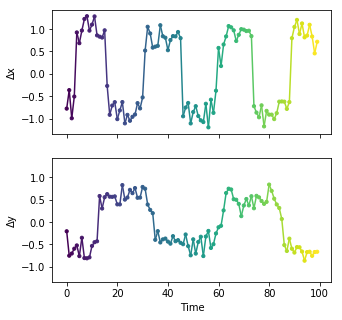

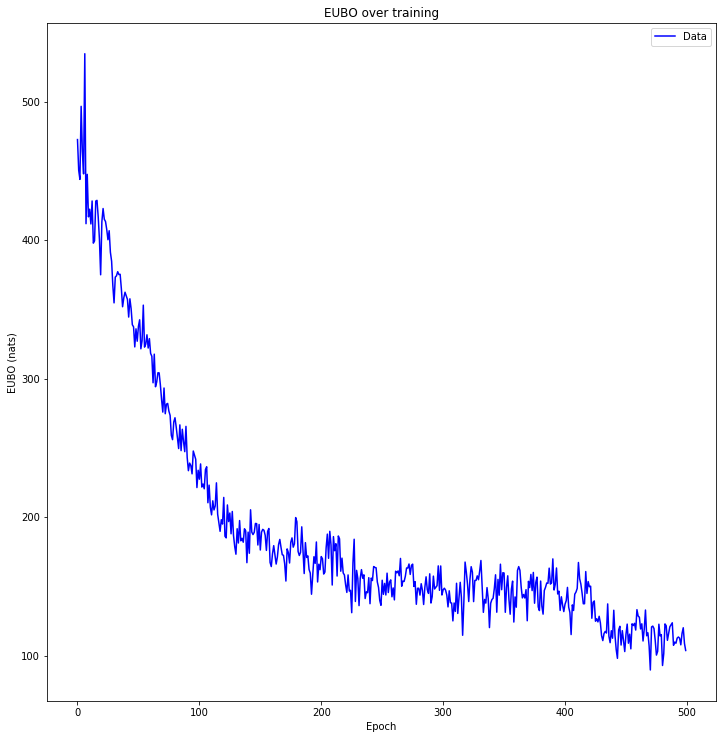

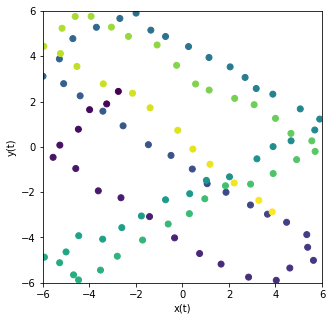

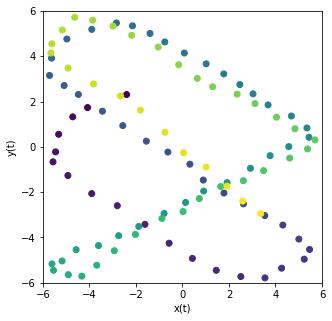

03/04/2019 13:43:24 MSE at time 0: tensor(0.1456)
03/04/2019 13:43:24 MSE at time 1: tensor(0.7024)
03/04/2019 13:43:24 MSE at time 2: tensor(0.6254)
03/04/2019 13:43:24 MSE at time 3: tensor(0.7690)
03/04/2019 13:43:24 MSE at time 4: tensor(0.1225)
03/04/2019 13:43:24 MSE at time 5: tensor(0.0402)
03/04/2019 13:43:24 MSE at time 6: tensor(0.2104)
03/04/2019 13:43:24 MSE at time 7: tensor(0.0955)
03/04/2019 13:43:24 MSE at time 8: tensor(0.1486)
03/04/2019 13:43:24 MSE at time 9: tensor(0.1550)
03/04/2019 13:43:24 MSE at time 10: tensor(0.1112)
03/04/2019 13:43:24 MSE at time 11: tensor(0.1415)
03/04/2019 13:43:24 MSE at time 12: tensor(0.1176)
03/04/2019 13:43:24 MSE at time 13: tensor(0.1129)
03/04/2019 13:43:24 MSE at time 14: tensor(0.2465)
03/04/2019 13:43:24 MSE at time 15: tensor(0.1250)
03/04/2019 13:43:24 MSE at time 16: tensor(0.1602)
03/04/2019 13:43:24 MSE at time 17: tensor(0.0162)
03/04/2019 13:43:24 MSE at time 18: tensor(0.1559)
03/04/2019 13:43:24 MSE at time 19: tenso

Epoch   284: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:44:21 EUBO=1.40772018e+02 at epoch 287
03/04/2019 13:44:22 EUBO=1.39920670e+02 at epoch 288
03/04/2019 13:44:22 EUBO=1.30191635e+02 at epoch 289
03/04/2019 13:44:22 EUBO=1.24398018e+02 at epoch 290
03/04/2019 13:44:22 EUBO=1.24963669e+02 at epoch 291
03/04/2019 13:44:22 EUBO=1.25549492e+02 at epoch 292
03/04/2019 13:44:23 EUBO=1.19564774e+02 at epoch 293
03/04/2019 13:44:23 EUBO=9.65073700e+01 at epoch 294
03/04/2019 13:44:23 EUBO=1.15254883e+02 at epoch 295
03/04/2019 13:44:23 EUBO=1.12307610e+02 at epoch 296
03/04/2019 13:44:23 EUBO=1.11574432e+02 at epoch 297
03/04/2019 13:44:24 EUBO=1.15971016e+02 at epoch 298
03/04/2019 13:44:24 EUBO=1.24309296e+02 at epoch 299
03/04/2019 13:44:24 EUBO=1.23100975e+02 at epoch 300
03/04/2019 13:44:24 EUBO=1.13104416e+02 at epoch 301
03/04/2019 13:44:25 EUBO=1.03063164e+02 at epoch 302
03/04/2019 13:44:25 EUBO=1.09491096e+02 at epoch 303
03/04/2019 13:44:25 EUBO=9.47072144e+01 at epoch 304
03/04/2019 13:44:25 EUBO=1.16019638e+02 at epo

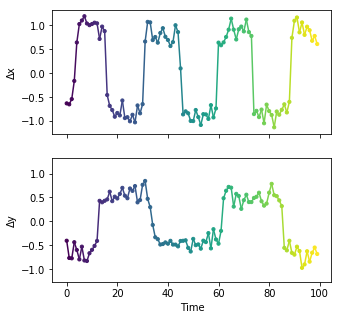

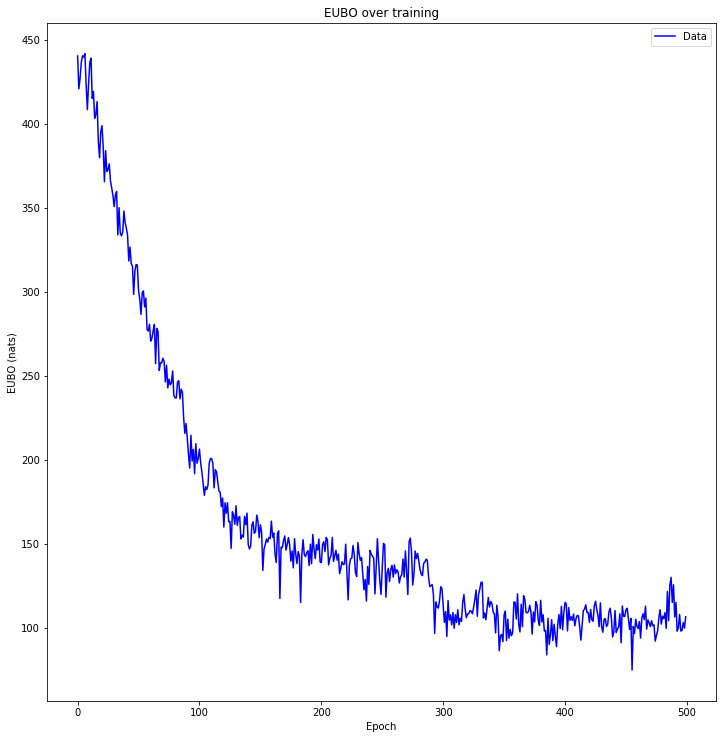

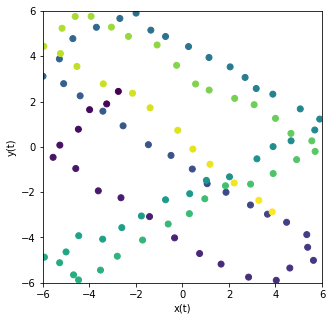

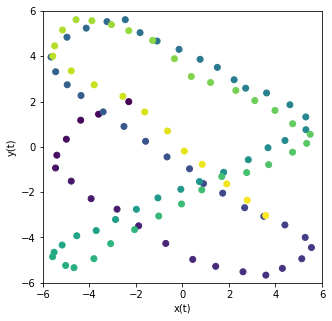

03/04/2019 13:45:04 MSE at time 0: tensor(0.4052)
03/04/2019 13:45:04 MSE at time 1: tensor(0.3300)
03/04/2019 13:45:04 MSE at time 2: tensor(0.3628)
03/04/2019 13:45:04 MSE at time 3: tensor(0.4619)
03/04/2019 13:45:04 MSE at time 4: tensor(0.2134)
03/04/2019 13:45:04 MSE at time 5: tensor(0.2334)
03/04/2019 13:45:04 MSE at time 6: tensor(0.3488)
03/04/2019 13:45:04 MSE at time 7: tensor(0.2158)
03/04/2019 13:45:04 MSE at time 8: tensor(0.2843)
03/04/2019 13:45:04 MSE at time 9: tensor(0.3870)
03/04/2019 13:45:04 MSE at time 10: tensor(0.2034)
03/04/2019 13:45:04 MSE at time 11: tensor(0.1542)
03/04/2019 13:45:04 MSE at time 12: tensor(0.0634)
03/04/2019 13:45:04 MSE at time 13: tensor(0.1140)
03/04/2019 13:45:04 MSE at time 14: tensor(0.2533)
03/04/2019 13:45:04 MSE at time 15: tensor(0.1030)
03/04/2019 13:45:04 MSE at time 16: tensor(0.2564)
03/04/2019 13:45:04 MSE at time 17: tensor(0.0267)
03/04/2019 13:45:04 MSE at time 18: tensor(0.0201)
03/04/2019 13:45:04 MSE at time 19: tenso

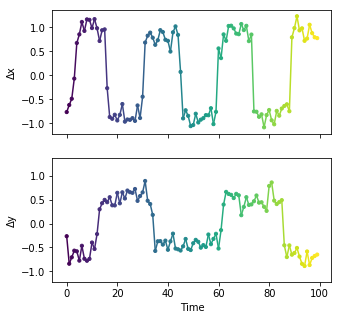

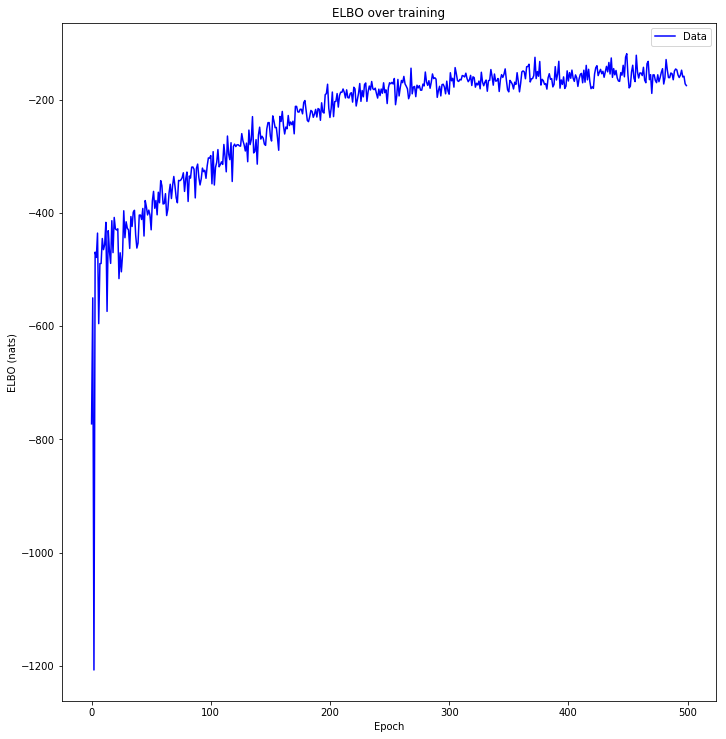

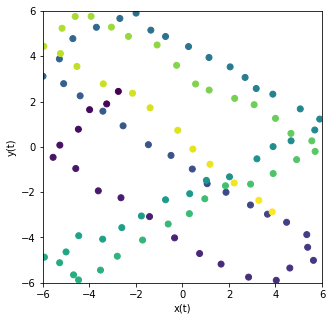

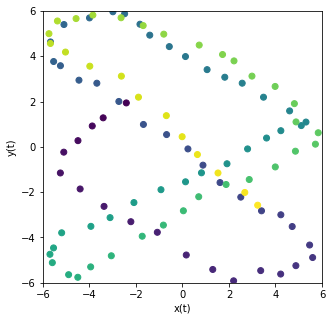

03/04/2019 13:46:44 MSE at time 0: tensor(0.3764)
03/04/2019 13:46:44 MSE at time 1: tensor(0.4002)
03/04/2019 13:46:44 MSE at time 2: tensor(0.5310)
03/04/2019 13:46:44 MSE at time 3: tensor(0.2551)
03/04/2019 13:46:44 MSE at time 4: tensor(0.1249)
03/04/2019 13:46:44 MSE at time 5: tensor(0.5750)
03/04/2019 13:46:44 MSE at time 6: tensor(0.8517)
03/04/2019 13:46:44 MSE at time 7: tensor(0.5326)
03/04/2019 13:46:44 MSE at time 8: tensor(1.3008)
03/04/2019 13:46:44 MSE at time 9: tensor(0.5928)
03/04/2019 13:46:44 MSE at time 10: tensor(0.8253)
03/04/2019 13:46:44 MSE at time 11: tensor(0.8163)
03/04/2019 13:46:44 MSE at time 12: tensor(0.8364)
03/04/2019 13:46:44 MSE at time 13: tensor(0.3546)
03/04/2019 13:46:44 MSE at time 14: tensor(0.1121)
03/04/2019 13:46:44 MSE at time 15: tensor(0.0789)
03/04/2019 13:46:44 MSE at time 16: tensor(0.0165)
03/04/2019 13:46:44 MSE at time 17: tensor(0.0170)
03/04/2019 13:46:44 MSE at time 18: tensor(0.5206)
03/04/2019 13:46:44 MSE at time 19: tenso

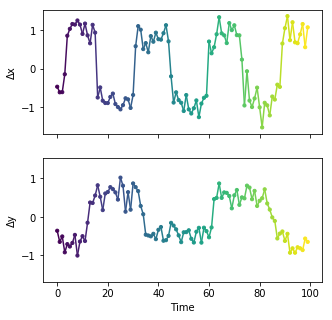

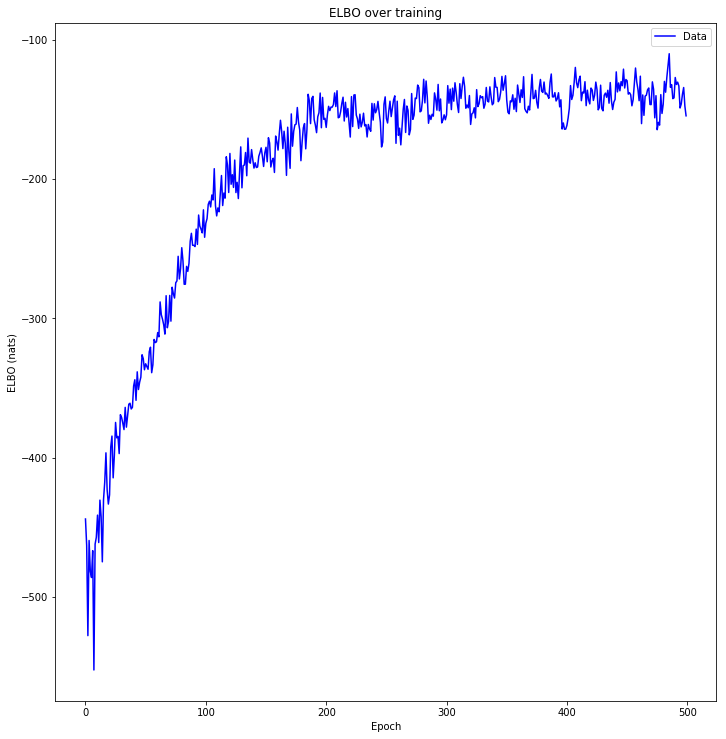

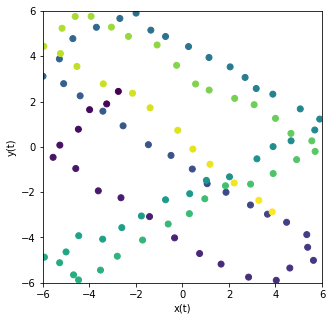

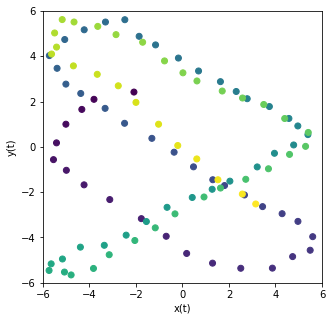

03/04/2019 13:48:17 MSE at time 0: tensor(0.4502)
03/04/2019 13:48:17 MSE at time 1: tensor(0.3396)
03/04/2019 13:48:17 MSE at time 2: tensor(0.1118)
03/04/2019 13:48:17 MSE at time 3: tensor(0.3368)
03/04/2019 13:48:17 MSE at time 4: tensor(0.0308)
03/04/2019 13:48:17 MSE at time 5: tensor(0.0107)
03/04/2019 13:48:17 MSE at time 6: tensor(0.1702)
03/04/2019 13:48:17 MSE at time 7: tensor(0.4452)
03/04/2019 13:48:17 MSE at time 8: tensor(0.2384)
03/04/2019 13:48:17 MSE at time 9: tensor(0.1323)
03/04/2019 13:48:17 MSE at time 10: tensor(0.1347)
03/04/2019 13:48:17 MSE at time 11: tensor(0.3096)
03/04/2019 13:48:17 MSE at time 12: tensor(0.1362)
03/04/2019 13:48:17 MSE at time 13: tensor(0.2661)
03/04/2019 13:48:17 MSE at time 14: tensor(0.3166)
03/04/2019 13:48:17 MSE at time 15: tensor(0.2687)
03/04/2019 13:48:17 MSE at time 16: tensor(0.2188)
03/04/2019 13:48:17 MSE at time 17: tensor(0.2664)
03/04/2019 13:48:17 MSE at time 18: tensor(0.4851)
03/04/2019 13:48:17 MSE at time 19: tenso

Epoch   291: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:49:17 ELBO=-1.18987213e+02 at epoch 294
03/04/2019 13:49:18 ELBO=-1.30917313e+02 at epoch 295
03/04/2019 13:49:18 ELBO=-1.28012833e+02 at epoch 296
03/04/2019 13:49:18 ELBO=-1.13309196e+02 at epoch 297
03/04/2019 13:49:18 ELBO=-1.19163589e+02 at epoch 298
03/04/2019 13:49:19 ELBO=-1.28861603e+02 at epoch 299
03/04/2019 13:49:19 ELBO=-1.27188942e+02 at epoch 300
03/04/2019 13:49:19 ELBO=-1.12962311e+02 at epoch 301
03/04/2019 13:49:19 ELBO=-1.18495293e+02 at epoch 302
03/04/2019 13:49:19 ELBO=-1.21222099e+02 at epoch 303
03/04/2019 13:49:20 ELBO=-1.14860718e+02 at epoch 304
03/04/2019 13:49:20 ELBO=-1.09111420e+02 at epoch 305
03/04/2019 13:49:20 ELBO=-1.18213432e+02 at epoch 306
03/04/2019 13:49:20 ELBO=-1.13062737e+02 at epoch 307
03/04/2019 13:49:20 ELBO=-1.15623703e+02 at epoch 308
03/04/2019 13:49:21 ELBO=-1.23084442e+02 at epoch 309
03/04/2019 13:49:21 ELBO=-1.22734406e+02 at epoch 310
03/04/2019 13:49:21 ELBO=-1.17421120e+02 at epoch 311
03/04/2019 13:49:21 ELBO=-1.

Epoch   457: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 13:49:53 ELBO=-1.05731842e+02 at epoch 460
03/04/2019 13:49:53 ELBO=-1.11980484e+02 at epoch 461
03/04/2019 13:49:53 ELBO=-1.18981827e+02 at epoch 462
03/04/2019 13:49:54 ELBO=-1.13650452e+02 at epoch 463
03/04/2019 13:49:54 ELBO=-1.07557671e+02 at epoch 464
03/04/2019 13:49:54 ELBO=-1.05577118e+02 at epoch 465
03/04/2019 13:49:54 ELBO=-1.08553825e+02 at epoch 466
03/04/2019 13:49:54 ELBO=-1.08236488e+02 at epoch 467
03/04/2019 13:49:55 ELBO=-1.00391922e+02 at epoch 468
03/04/2019 13:49:55 ELBO=-1.13971710e+02 at epoch 469
03/04/2019 13:49:55 ELBO=-9.42608414e+01 at epoch 470
03/04/2019 13:49:55 ELBO=-9.73923569e+01 at epoch 471
03/04/2019 13:49:55 ELBO=-9.30291519e+01 at epoch 472
03/04/2019 13:49:56 ELBO=-9.27898102e+01 at epoch 473
03/04/2019 13:49:56 ELBO=-8.95082092e+01 at epoch 474
03/04/2019 13:49:56 ELBO=-9.33600235e+01 at epoch 475
03/04/2019 13:49:56 ELBO=-9.16585770e+01 at epoch 476
03/04/2019 13:49:56 ELBO=-9.23271790e+01 at epoch 477
03/04/2019 13:49:57 ELBO=-1.

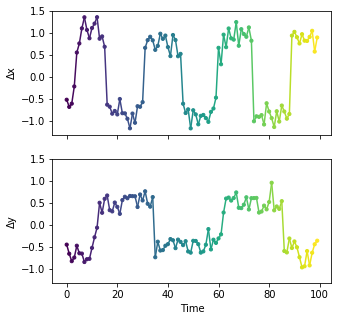

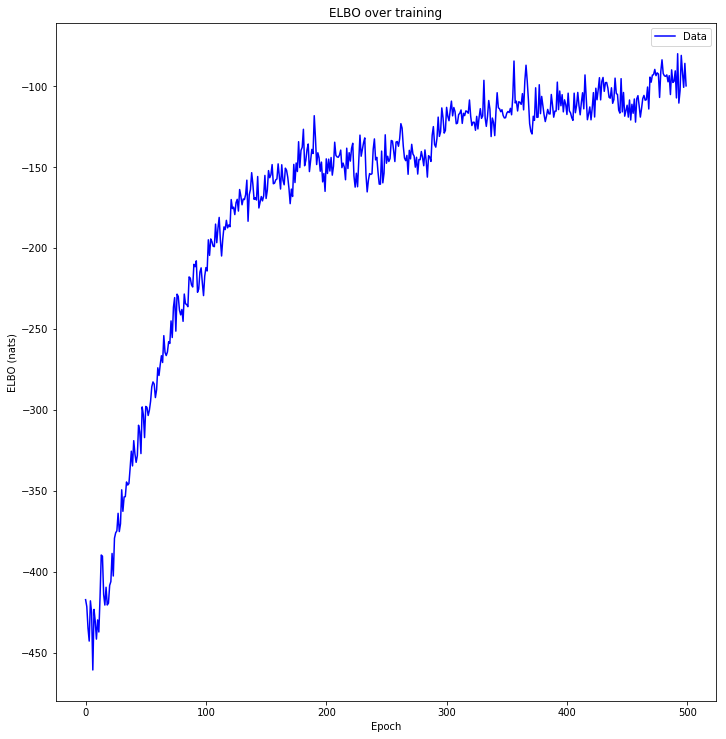

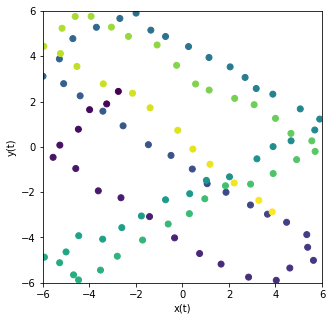

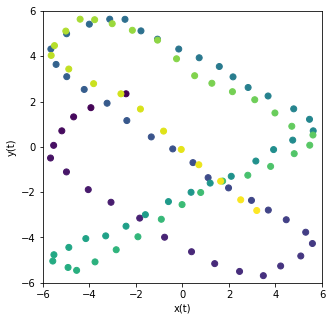

03/04/2019 13:50:02 MSE at time 0: tensor(0.1200)
03/04/2019 13:50:02 MSE at time 1: tensor(0.4876)
03/04/2019 13:50:02 MSE at time 2: tensor(0.5728)
03/04/2019 13:50:02 MSE at time 3: tensor(0.5123)
03/04/2019 13:50:02 MSE at time 4: tensor(0.0711)
03/04/2019 13:50:02 MSE at time 5: tensor(0.0132)
03/04/2019 13:50:02 MSE at time 6: tensor(0.1835)
03/04/2019 13:50:02 MSE at time 7: tensor(0.1893)
03/04/2019 13:50:02 MSE at time 8: tensor(0.2237)
03/04/2019 13:50:02 MSE at time 9: tensor(0.1832)
03/04/2019 13:50:02 MSE at time 10: tensor(0.1854)
03/04/2019 13:50:02 MSE at time 11: tensor(0.1265)
03/04/2019 13:50:02 MSE at time 12: tensor(0.0755)
03/04/2019 13:50:02 MSE at time 13: tensor(0.2143)
03/04/2019 13:50:02 MSE at time 14: tensor(0.3517)
03/04/2019 13:50:02 MSE at time 15: tensor(0.1636)
03/04/2019 13:50:02 MSE at time 16: tensor(0.3336)
03/04/2019 13:50:02 MSE at time 17: tensor(0.0697)
03/04/2019 13:50:02 MSE at time 18: tensor(0.0132)
03/04/2019 13:50:02 MSE at time 19: tenso

Epoch   440: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:51:30 EUBO=1.65400314e+02 at epoch 443
03/04/2019 13:51:30 EUBO=1.40963104e+02 at epoch 444
03/04/2019 13:51:31 EUBO=1.51102463e+02 at epoch 445
03/04/2019 13:51:31 EUBO=1.41021317e+02 at epoch 446
03/04/2019 13:51:31 EUBO=1.45014236e+02 at epoch 447
03/04/2019 13:51:31 EUBO=1.38166153e+02 at epoch 448
03/04/2019 13:51:31 EUBO=1.54056900e+02 at epoch 449
03/04/2019 13:51:32 EUBO=1.26906952e+02 at epoch 450
03/04/2019 13:51:32 EUBO=1.45454681e+02 at epoch 451
03/04/2019 13:51:32 EUBO=1.24590607e+02 at epoch 452
03/04/2019 13:51:32 EUBO=1.33023376e+02 at epoch 453
03/04/2019 13:51:32 EUBO=1.48392868e+02 at epoch 454
03/04/2019 13:51:33 EUBO=1.29509903e+02 at epoch 455
03/04/2019 13:51:33 EUBO=1.32961655e+02 at epoch 456
03/04/2019 13:51:33 EUBO=1.54396927e+02 at epoch 457
03/04/2019 13:51:33 EUBO=1.32941025e+02 at epoch 458
03/04/2019 13:51:34 EUBO=1.36926178e+02 at epoch 459
03/04/2019 13:51:34 EUBO=1.33367783e+02 at epoch 460
03/04/2019 13:51:34 EUBO=1.34332611e+02 at epo

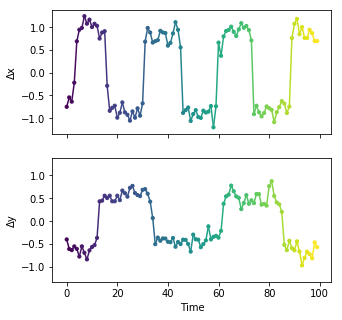

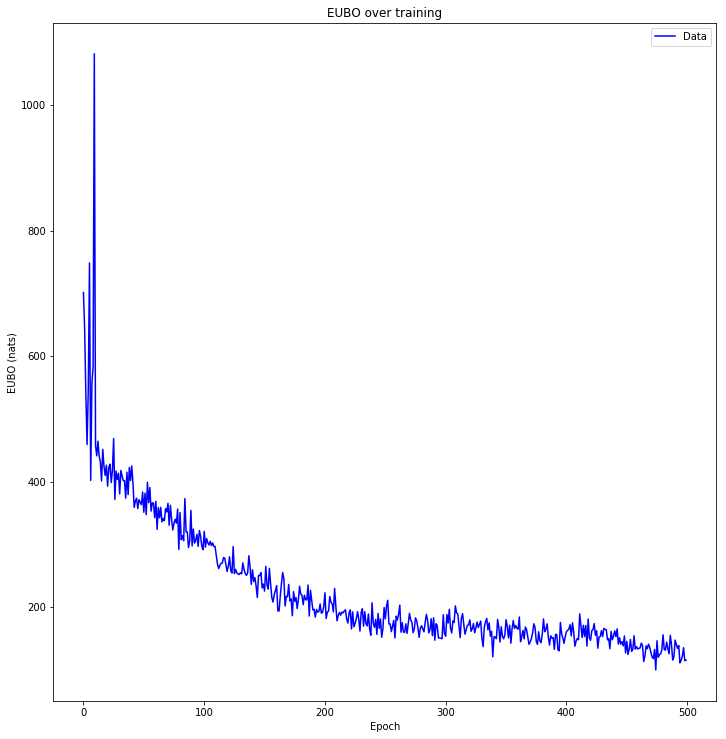

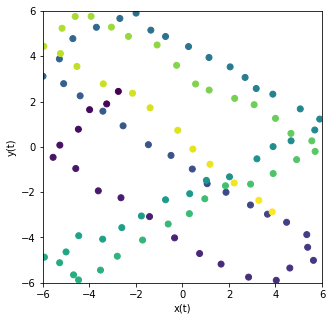

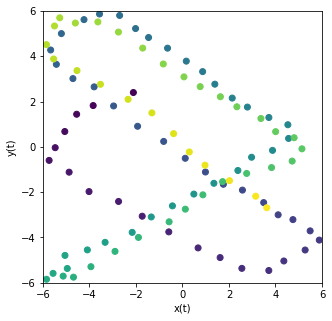

03/04/2019 13:51:43 MSE at time 0: tensor(0.4198)
03/04/2019 13:51:43 MSE at time 1: tensor(0.3425)
03/04/2019 13:51:43 MSE at time 2: tensor(0.3505)
03/04/2019 13:51:43 MSE at time 3: tensor(0.3507)
03/04/2019 13:51:43 MSE at time 4: tensor(0.0525)
03/04/2019 13:51:43 MSE at time 5: tensor(0.0477)
03/04/2019 13:51:43 MSE at time 6: tensor(0.1079)
03/04/2019 13:51:43 MSE at time 7: tensor(0.1607)
03/04/2019 13:51:43 MSE at time 8: tensor(0.0378)
03/04/2019 13:51:43 MSE at time 9: tensor(0.0995)
03/04/2019 13:51:43 MSE at time 10: tensor(0.1320)
03/04/2019 13:51:43 MSE at time 11: tensor(0.0658)
03/04/2019 13:51:43 MSE at time 12: tensor(0.0845)
03/04/2019 13:51:43 MSE at time 13: tensor(0.2333)
03/04/2019 13:51:43 MSE at time 14: tensor(0.2895)
03/04/2019 13:51:43 MSE at time 15: tensor(0.1626)
03/04/2019 13:51:43 MSE at time 16: tensor(0.3359)
03/04/2019 13:51:43 MSE at time 17: tensor(0.3513)
03/04/2019 13:51:43 MSE at time 18: tensor(0.0482)
03/04/2019 13:51:43 MSE at time 19: tenso

Epoch   382: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:52:56 EUBO=1.50541290e+02 at epoch 385
03/04/2019 13:52:56 EUBO=1.50211166e+02 at epoch 386
03/04/2019 13:52:57 EUBO=1.31404877e+02 at epoch 387
03/04/2019 13:52:57 EUBO=1.42022629e+02 at epoch 388
03/04/2019 13:52:57 EUBO=1.34267120e+02 at epoch 389
03/04/2019 13:52:57 EUBO=1.33033951e+02 at epoch 390
03/04/2019 13:52:57 EUBO=1.22667206e+02 at epoch 391
03/04/2019 13:52:57 EUBO=1.25680984e+02 at epoch 392
03/04/2019 13:52:58 EUBO=1.34883560e+02 at epoch 393
03/04/2019 13:52:58 EUBO=1.32563614e+02 at epoch 394
03/04/2019 13:52:58 EUBO=1.30578979e+02 at epoch 395
03/04/2019 13:52:58 EUBO=1.29993454e+02 at epoch 396
03/04/2019 13:52:58 EUBO=1.25731293e+02 at epoch 397
03/04/2019 13:52:59 EUBO=1.17721176e+02 at epoch 398
03/04/2019 13:52:59 EUBO=1.17709656e+02 at epoch 399
03/04/2019 13:52:59 EUBO=1.28228378e+02 at epoch 400
03/04/2019 13:52:59 EUBO=1.15130119e+02 at epoch 401
03/04/2019 13:52:59 EUBO=1.11224686e+02 at epoch 402
03/04/2019 13:53:00 EUBO=1.39983398e+02 at epo

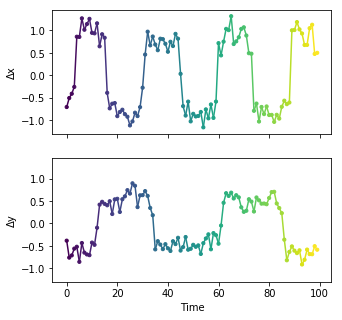

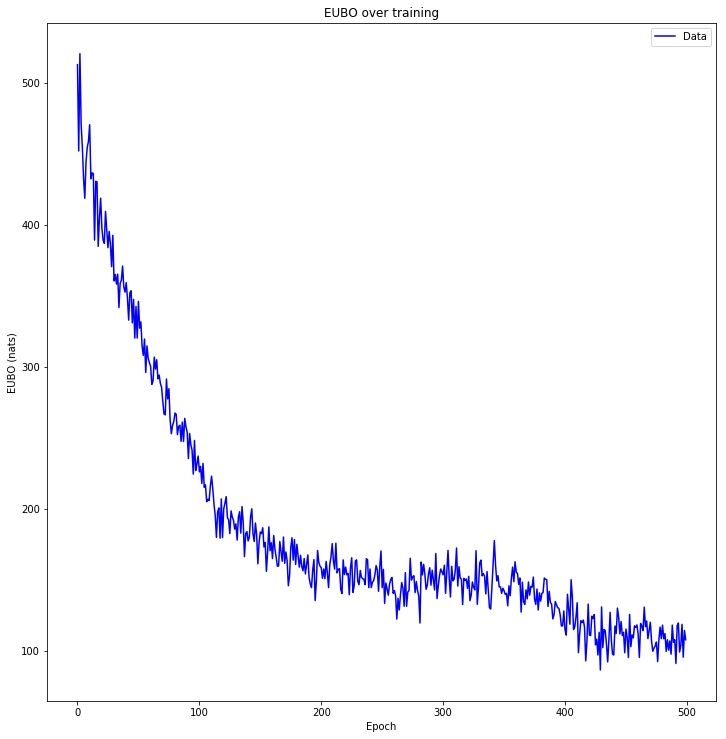

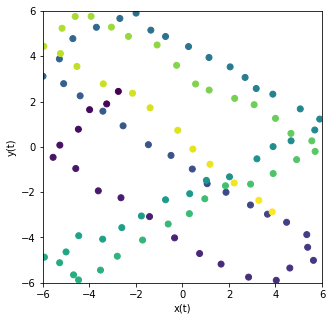

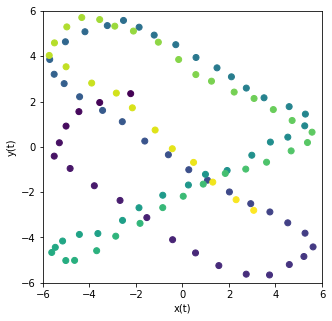

03/04/2019 13:53:18 MSE at time 0: tensor(0.2911)
03/04/2019 13:53:18 MSE at time 1: tensor(0.0938)
03/04/2019 13:53:18 MSE at time 2: tensor(0.2191)
03/04/2019 13:53:18 MSE at time 3: tensor(0.3000)
03/04/2019 13:53:18 MSE at time 4: tensor(0.0115)
03/04/2019 13:53:18 MSE at time 5: tensor(0.0051)
03/04/2019 13:53:18 MSE at time 6: tensor(0.0589)
03/04/2019 13:53:18 MSE at time 7: tensor(0.0796)
03/04/2019 13:53:18 MSE at time 8: tensor(0.0157)
03/04/2019 13:53:18 MSE at time 9: tensor(0.0155)
03/04/2019 13:53:18 MSE at time 10: tensor(0.0138)
03/04/2019 13:53:18 MSE at time 11: tensor(0.0315)
03/04/2019 13:53:18 MSE at time 12: tensor(0.0135)
03/04/2019 13:53:18 MSE at time 13: tensor(0.0273)
03/04/2019 13:53:18 MSE at time 14: tensor(0.1397)
03/04/2019 13:53:18 MSE at time 15: tensor(0.0241)
03/04/2019 13:53:18 MSE at time 16: tensor(0.1970)
03/04/2019 13:53:18 MSE at time 17: tensor(0.0545)
03/04/2019 13:53:18 MSE at time 18: tensor(0.0096)
03/04/2019 13:53:18 MSE at time 19: tenso

Epoch   311: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:54:26 EUBO=1.42945923e+02 at epoch 313
03/04/2019 13:54:26 EUBO=1.38716110e+02 at epoch 314
03/04/2019 13:54:26 EUBO=1.40502457e+02 at epoch 315
03/04/2019 13:54:26 EUBO=1.17240211e+02 at epoch 316
03/04/2019 13:54:27 EUBO=1.36705414e+02 at epoch 317
03/04/2019 13:54:27 EUBO=1.23638176e+02 at epoch 318
03/04/2019 13:54:27 EUBO=1.23296928e+02 at epoch 319
03/04/2019 13:54:27 EUBO=1.17469513e+02 at epoch 320
03/04/2019 13:54:27 EUBO=1.19160675e+02 at epoch 321
03/04/2019 13:54:28 EUBO=1.23667984e+02 at epoch 322
03/04/2019 13:54:28 EUBO=1.23665459e+02 at epoch 323
03/04/2019 13:54:28 EUBO=1.26156593e+02 at epoch 324
03/04/2019 13:54:28 EUBO=1.30306671e+02 at epoch 325
03/04/2019 13:54:28 EUBO=1.16072235e+02 at epoch 326
03/04/2019 13:54:29 EUBO=1.31316055e+02 at epoch 327
03/04/2019 13:54:29 EUBO=1.04968254e+02 at epoch 328
03/04/2019 13:54:29 EUBO=1.28865448e+02 at epoch 329
03/04/2019 13:54:29 EUBO=1.19263588e+02 at epoch 330
03/04/2019 13:54:29 EUBO=1.13592369e+02 at epo

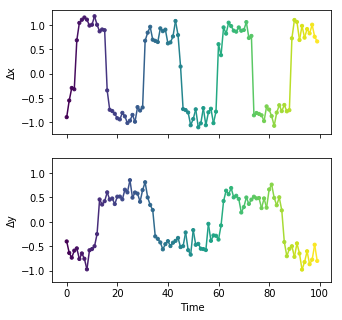

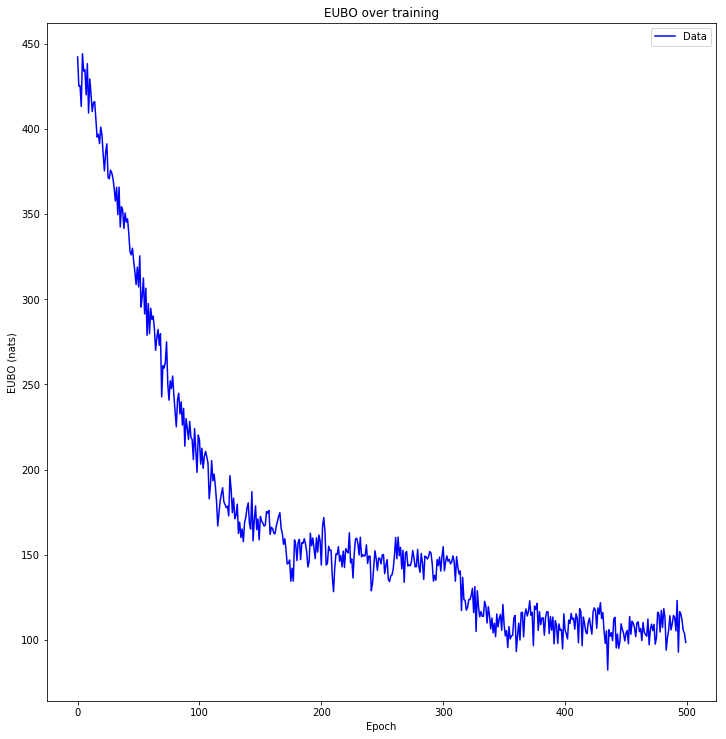

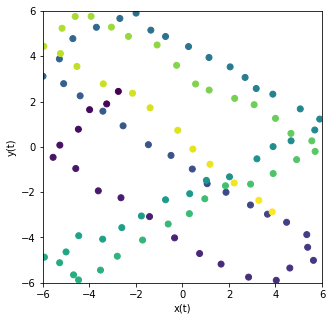

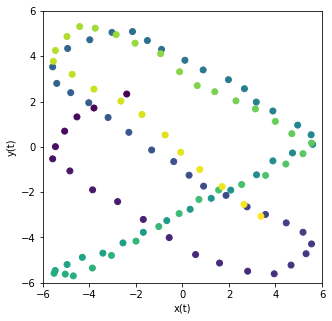

03/04/2019 13:55:03 MSE at time 0: tensor(0.1435)
03/04/2019 13:55:03 MSE at time 1: tensor(0.3319)
03/04/2019 13:55:03 MSE at time 2: tensor(0.3975)
03/04/2019 13:55:03 MSE at time 3: tensor(0.3561)
03/04/2019 13:55:03 MSE at time 4: tensor(0.0405)
03/04/2019 13:55:03 MSE at time 5: tensor(0.0049)
03/04/2019 13:55:03 MSE at time 6: tensor(0.0756)
03/04/2019 13:55:03 MSE at time 7: tensor(0.0619)
03/04/2019 13:55:03 MSE at time 8: tensor(0.0499)
03/04/2019 13:55:03 MSE at time 9: tensor(0.0882)
03/04/2019 13:55:03 MSE at time 10: tensor(0.0535)
03/04/2019 13:55:03 MSE at time 11: tensor(0.0315)
03/04/2019 13:55:03 MSE at time 12: tensor(0.0065)
03/04/2019 13:55:03 MSE at time 13: tensor(0.0701)
03/04/2019 13:55:03 MSE at time 14: tensor(0.0897)
03/04/2019 13:55:03 MSE at time 15: tensor(0.0196)
03/04/2019 13:55:03 MSE at time 16: tensor(0.1862)
03/04/2019 13:55:03 MSE at time 17: tensor(0.0496)
03/04/2019 13:55:03 MSE at time 18: tensor(0.0373)
03/04/2019 13:55:03 MSE at time 19: tenso

Epoch   203: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:55:51 ELBO=-6.28495789e+02 at epoch 206
03/04/2019 13:55:51 ELBO=-6.13242798e+02 at epoch 207
03/04/2019 13:55:52 ELBO=-6.52300842e+02 at epoch 208
03/04/2019 13:55:52 ELBO=-6.23449036e+02 at epoch 209
03/04/2019 13:55:52 ELBO=-6.25135010e+02 at epoch 210
03/04/2019 13:55:52 ELBO=-6.41032593e+02 at epoch 211
03/04/2019 13:55:53 ELBO=-6.35373901e+02 at epoch 212
03/04/2019 13:55:53 ELBO=-6.27253113e+02 at epoch 213
03/04/2019 13:55:53 ELBO=-6.24711731e+02 at epoch 214
03/04/2019 13:55:53 ELBO=-6.34198792e+02 at epoch 215
03/04/2019 13:55:54 ELBO=-6.23059509e+02 at epoch 216
03/04/2019 13:55:54 ELBO=-6.27139893e+02 at epoch 217
03/04/2019 13:55:54 ELBO=-6.29664246e+02 at epoch 218
03/04/2019 13:55:54 ELBO=-6.25932556e+02 at epoch 219
03/04/2019 13:55:55 ELBO=-6.16920227e+02 at epoch 220
03/04/2019 13:55:55 ELBO=-6.35309875e+02 at epoch 221
03/04/2019 13:55:55 ELBO=-6.33855103e+02 at epoch 222
03/04/2019 13:55:55 ELBO=-6.39602173e+02 at epoch 223
03/04/2019 13:55:55 ELBO=-6.

Epoch   304: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 13:56:16 ELBO=-6.69594055e+02 at epoch 307
03/04/2019 13:56:16 ELBO=-6.46366150e+02 at epoch 308
03/04/2019 13:56:16 ELBO=-6.45096130e+02 at epoch 309
03/04/2019 13:56:17 ELBO=-6.26244202e+02 at epoch 310
03/04/2019 13:56:17 ELBO=-6.34380981e+02 at epoch 311
03/04/2019 13:56:17 ELBO=-6.17477844e+02 at epoch 312
03/04/2019 13:56:17 ELBO=-6.17154724e+02 at epoch 313
03/04/2019 13:56:18 ELBO=-6.36711731e+02 at epoch 314
03/04/2019 13:56:18 ELBO=-6.23480774e+02 at epoch 315
03/04/2019 13:56:18 ELBO=-6.30721741e+02 at epoch 316
03/04/2019 13:56:18 ELBO=-6.15969849e+02 at epoch 317
03/04/2019 13:56:19 ELBO=-6.34761292e+02 at epoch 318
03/04/2019 13:56:19 ELBO=-6.48253906e+02 at epoch 319
03/04/2019 13:56:19 ELBO=-6.38368835e+02 at epoch 320
03/04/2019 13:56:19 ELBO=-6.14860474e+02 at epoch 321
03/04/2019 13:56:20 ELBO=-6.33228638e+02 at epoch 322
03/04/2019 13:56:20 ELBO=-6.09576233e+02 at epoch 323
03/04/2019 13:56:20 ELBO=-6.38096619e+02 at epoch 324
03/04/2019 13:56:20 ELBO=-6.

Epoch   405: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 13:56:40 ELBO=-6.32422607e+02 at epoch 408
03/04/2019 13:56:41 ELBO=-6.18083252e+02 at epoch 409
03/04/2019 13:56:41 ELBO=-6.45410461e+02 at epoch 410
03/04/2019 13:56:41 ELBO=-6.27929871e+02 at epoch 411
03/04/2019 13:56:41 ELBO=-6.25286804e+02 at epoch 412
03/04/2019 13:56:42 ELBO=-6.36535706e+02 at epoch 413
03/04/2019 13:56:42 ELBO=-6.33103638e+02 at epoch 414
03/04/2019 13:56:42 ELBO=-6.49890381e+02 at epoch 415
03/04/2019 13:56:42 ELBO=-6.45226013e+02 at epoch 416
03/04/2019 13:56:43 ELBO=-6.33358887e+02 at epoch 417
03/04/2019 13:56:43 ELBO=-6.54858704e+02 at epoch 418
03/04/2019 13:56:43 ELBO=-6.29264282e+02 at epoch 419
03/04/2019 13:56:43 ELBO=-6.33675659e+02 at epoch 420
03/04/2019 13:56:44 ELBO=-6.25554871e+02 at epoch 421
03/04/2019 13:56:44 ELBO=-6.30718750e+02 at epoch 422
03/04/2019 13:56:44 ELBO=-6.23040649e+02 at epoch 423
03/04/2019 13:56:44 ELBO=-6.18777039e+02 at epoch 424
03/04/2019 13:56:45 ELBO=-6.17644226e+02 at epoch 425
03/04/2019 13:56:45 ELBO=-6.

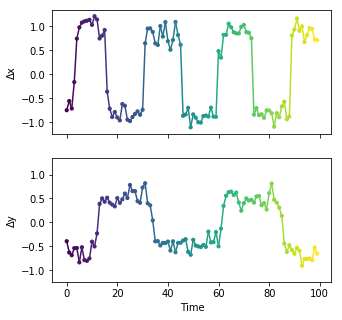

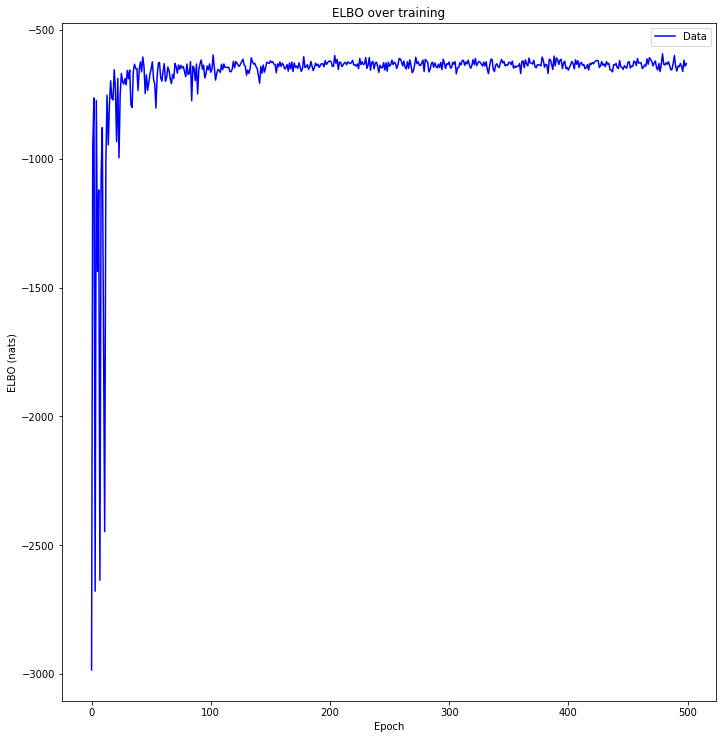

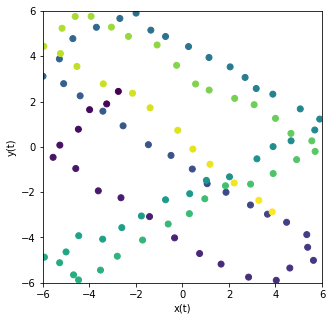

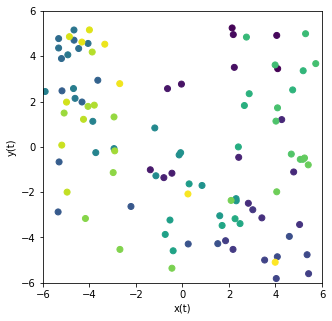

03/04/2019 13:57:04 MSE at time 0: tensor(47.9594)
03/04/2019 13:57:04 MSE at time 1: tensor(40.3623)
03/04/2019 13:57:04 MSE at time 2: tensor(75.5315)
03/04/2019 13:57:04 MSE at time 3: tensor(61.8553)
03/04/2019 13:57:04 MSE at time 4: tensor(68.0963)
03/04/2019 13:57:04 MSE at time 5: tensor(40.9217)
03/04/2019 13:57:04 MSE at time 6: tensor(28.0139)
03/04/2019 13:57:04 MSE at time 7: tensor(5.8679)
03/04/2019 13:57:04 MSE at time 8: tensor(5.9745)
03/04/2019 13:57:04 MSE at time 9: tensor(3.3375)
03/04/2019 13:57:04 MSE at time 10: tensor(20.2497)
03/04/2019 13:57:04 MSE at time 11: tensor(47.4431)
03/04/2019 13:57:04 MSE at time 12: tensor(26.2963)
03/04/2019 13:57:04 MSE at time 13: tensor(10.6335)
03/04/2019 13:57:04 MSE at time 14: tensor(7.9846)
03/04/2019 13:57:04 MSE at time 15: tensor(3.8588)
03/04/2019 13:57:04 MSE at time 16: tensor(11.7983)
03/04/2019 13:57:04 MSE at time 17: tensor(10.3127)
03/04/2019 13:57:04 MSE at time 18: tensor(12.2729)
03/04/2019 13:57:04 MSE at 

Epoch   381: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 13:58:45 ELBO=-2.28992401e+02 at epoch 384
03/04/2019 13:58:46 ELBO=-2.86637726e+02 at epoch 385
03/04/2019 13:58:46 ELBO=-2.73385162e+02 at epoch 386
03/04/2019 13:58:46 ELBO=-2.37984406e+02 at epoch 387
03/04/2019 13:58:46 ELBO=-2.65295380e+02 at epoch 388
03/04/2019 13:58:47 ELBO=-2.36779999e+02 at epoch 389
03/04/2019 13:58:47 ELBO=-2.34278244e+02 at epoch 390
03/04/2019 13:58:47 ELBO=-2.47960358e+02 at epoch 391
03/04/2019 13:58:47 ELBO=-2.68423035e+02 at epoch 392
03/04/2019 13:58:47 ELBO=-2.41090256e+02 at epoch 393
03/04/2019 13:58:48 ELBO=-2.48321014e+02 at epoch 394
03/04/2019 13:58:48 ELBO=-2.03359238e+02 at epoch 395
03/04/2019 13:58:48 ELBO=-2.32726715e+02 at epoch 396
03/04/2019 13:58:48 ELBO=-2.54854584e+02 at epoch 397
03/04/2019 13:58:49 ELBO=-2.41691376e+02 at epoch 398
03/04/2019 13:58:49 ELBO=-2.48202728e+02 at epoch 399
03/04/2019 13:58:49 ELBO=-2.51181549e+02 at epoch 400
03/04/2019 13:58:49 ELBO=-2.33385406e+02 at epoch 401
03/04/2019 13:58:50 ELBO=-2.

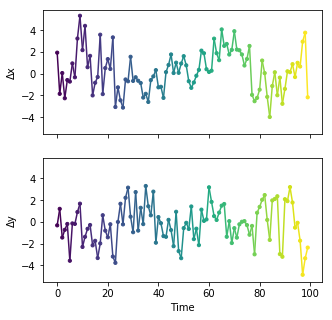

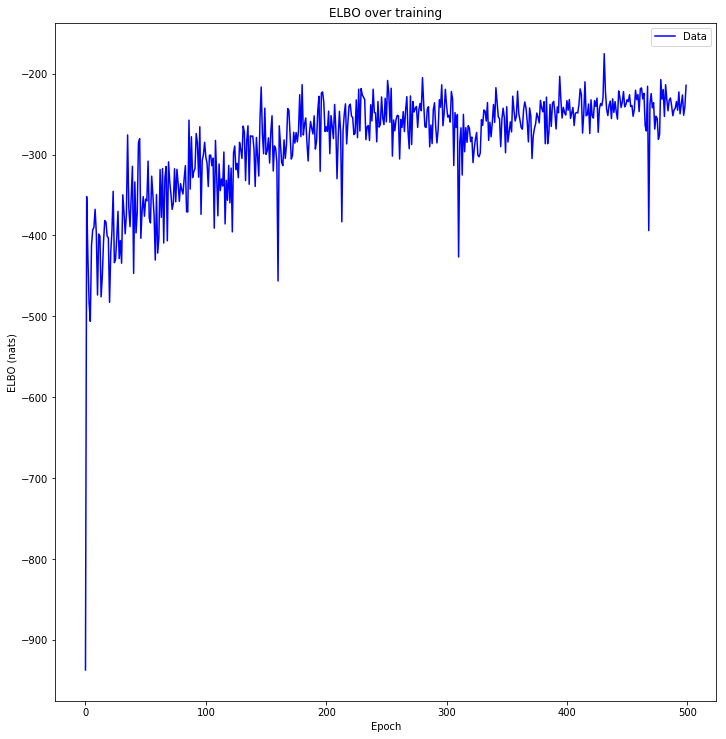

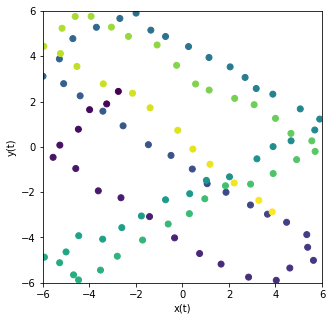

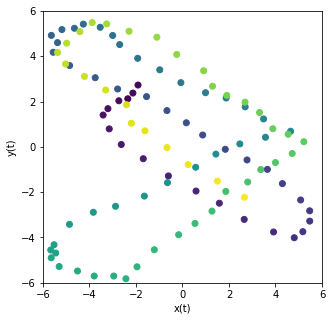

03/04/2019 13:59:16 MSE at time 0: tensor(0.2718)
03/04/2019 13:59:16 MSE at time 1: tensor(2.5095)
03/04/2019 13:59:16 MSE at time 2: tensor(4.0071)
03/04/2019 13:59:16 MSE at time 3: tensor(4.6077)
03/04/2019 13:59:16 MSE at time 4: tensor(6.8673)
03/04/2019 13:59:16 MSE at time 5: tensor(8.1140)
03/04/2019 13:59:16 MSE at time 6: tensor(5.1329)
03/04/2019 13:59:16 MSE at time 7: tensor(5.1537)
03/04/2019 13:59:16 MSE at time 8: tensor(3.8851)
03/04/2019 13:59:16 MSE at time 9: tensor(3.8789)
03/04/2019 13:59:16 MSE at time 10: tensor(5.1267)
03/04/2019 13:59:16 MSE at time 11: tensor(5.6580)
03/04/2019 13:59:16 MSE at time 12: tensor(4.8825)
03/04/2019 13:59:16 MSE at time 13: tensor(5.1252)
03/04/2019 13:59:16 MSE at time 14: tensor(4.1317)
03/04/2019 13:59:16 MSE at time 15: tensor(2.8916)
03/04/2019 13:59:16 MSE at time 16: tensor(3.0270)
03/04/2019 13:59:16 MSE at time 17: tensor(2.6017)
03/04/2019 13:59:16 MSE at time 18: tensor(2.4072)
03/04/2019 13:59:16 MSE at time 19: tenso

Epoch   135: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 14:00:00 ELBO=-2.91047668e+02 at epoch 137
03/04/2019 14:00:00 ELBO=-2.69536530e+02 at epoch 138
03/04/2019 14:00:00 ELBO=-2.60115906e+02 at epoch 139
03/04/2019 14:00:01 ELBO=-3.59494690e+02 at epoch 140
03/04/2019 14:00:01 ELBO=-3.55603424e+02 at epoch 141
03/04/2019 14:00:01 ELBO=-3.65192688e+02 at epoch 142
03/04/2019 14:00:01 ELBO=-4.44903168e+02 at epoch 143
03/04/2019 14:00:02 ELBO=-4.30576904e+02 at epoch 144
03/04/2019 14:00:02 ELBO=-3.77199921e+02 at epoch 145
03/04/2019 14:00:02 ELBO=-3.03548706e+02 at epoch 146
03/04/2019 14:00:03 ELBO=-2.92212921e+02 at epoch 147
03/04/2019 14:00:03 ELBO=-3.01191589e+02 at epoch 148
03/04/2019 14:00:03 ELBO=-3.35034027e+02 at epoch 149
03/04/2019 14:00:04 ELBO=-4.06666687e+02 at epoch 150
03/04/2019 14:00:04 ELBO=-2.56803314e+02 at epoch 151
03/04/2019 14:00:04 ELBO=-4.15905121e+02 at epoch 152
03/04/2019 14:00:05 ELBO=-3.35992065e+02 at epoch 153
03/04/2019 14:00:05 ELBO=-2.77672668e+02 at epoch 154
03/04/2019 14:00:05 ELBO=-1.

Epoch   319: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 14:01:00 ELBO=-4.14253937e+02 at epoch 321
03/04/2019 14:01:01 ELBO=-2.67075714e+02 at epoch 322
03/04/2019 14:01:01 ELBO=-2.45893188e+02 at epoch 323
03/04/2019 14:01:01 ELBO=-3.54993988e+02 at epoch 324
03/04/2019 14:01:02 ELBO=-7.03679993e+02 at epoch 325
03/04/2019 14:01:02 ELBO=-2.05545990e+02 at epoch 326
03/04/2019 14:01:02 ELBO=-2.56033142e+02 at epoch 327
03/04/2019 14:01:03 ELBO=-3.53661560e+02 at epoch 328
03/04/2019 14:01:03 ELBO=-3.34068329e+02 at epoch 329
03/04/2019 14:01:03 ELBO=-1.86846344e+02 at epoch 330
03/04/2019 14:01:04 ELBO=-2.44848267e+02 at epoch 331
03/04/2019 14:01:04 ELBO=-4.14363251e+02 at epoch 332
03/04/2019 14:01:04 ELBO=-4.01357147e+02 at epoch 333
03/04/2019 14:01:05 ELBO=-3.94085968e+02 at epoch 334
03/04/2019 14:01:05 ELBO=-2.88418579e+02 at epoch 335
03/04/2019 14:01:05 ELBO=-3.53931763e+02 at epoch 336
03/04/2019 14:01:06 ELBO=-3.65601013e+02 at epoch 337
03/04/2019 14:01:06 ELBO=-4.27738251e+02 at epoch 338
03/04/2019 14:01:06 ELBO=-2.

Epoch   452: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 14:01:44 ELBO=-3.39480621e+02 at epoch 454
03/04/2019 14:01:45 ELBO=-3.39730927e+02 at epoch 455
03/04/2019 14:01:45 ELBO=-3.81092651e+02 at epoch 456
03/04/2019 14:01:45 ELBO=-2.58037781e+02 at epoch 457
03/04/2019 14:01:46 ELBO=-3.24738312e+02 at epoch 458
03/04/2019 14:01:46 ELBO=-1.12468330e+02 at epoch 459
03/04/2019 14:01:46 ELBO=-3.22257141e+02 at epoch 460
03/04/2019 14:01:47 ELBO=-2.69340302e+02 at epoch 461
03/04/2019 14:01:47 ELBO=-3.61818115e+02 at epoch 462
03/04/2019 14:01:47 ELBO=-3.82167999e+02 at epoch 463
03/04/2019 14:01:47 ELBO=-6.96860413e+02 at epoch 464
03/04/2019 14:01:48 ELBO=-2.19327682e+02 at epoch 465
03/04/2019 14:01:48 ELBO=-4.16728271e+02 at epoch 466
03/04/2019 14:01:48 ELBO=-3.89126678e+02 at epoch 467
03/04/2019 14:01:49 ELBO=-3.43959534e+02 at epoch 468
03/04/2019 14:01:49 ELBO=-3.96243011e+02 at epoch 469
03/04/2019 14:01:49 ELBO=-3.16496246e+02 at epoch 470
03/04/2019 14:01:50 ELBO=-2.59605469e+02 at epoch 471
03/04/2019 14:01:50 ELBO=-2.

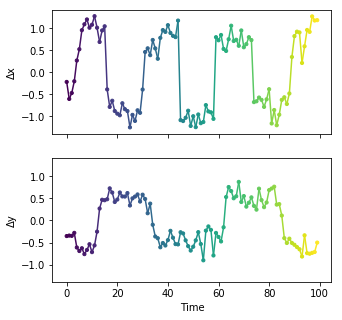

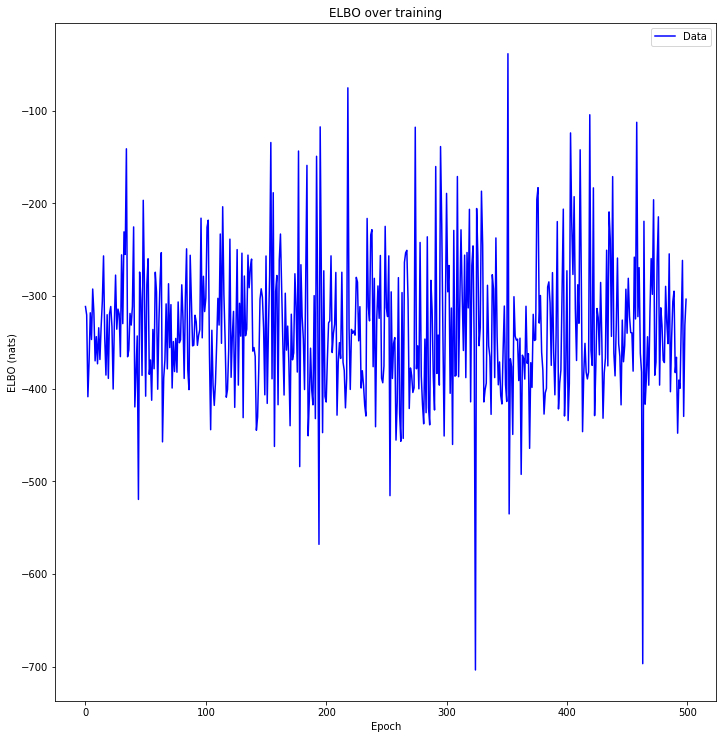

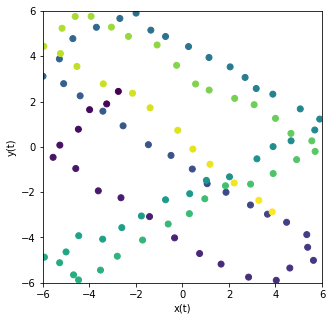

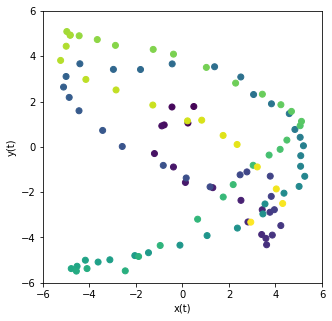

03/04/2019 14:01:59 MSE at time 0: tensor(10.9050)
03/04/2019 14:01:59 MSE at time 1: tensor(14.0595)
03/04/2019 14:01:59 MSE at time 2: tensor(12.5727)
03/04/2019 14:01:59 MSE at time 3: tensor(13.6628)
03/04/2019 14:01:59 MSE at time 4: tensor(19.9529)
03/04/2019 14:01:59 MSE at time 5: tensor(19.0296)
03/04/2019 14:01:59 MSE at time 6: tensor(17.6554)
03/04/2019 14:01:59 MSE at time 7: tensor(14.1697)
03/04/2019 14:01:59 MSE at time 8: tensor(15.7958)
03/04/2019 14:01:59 MSE at time 9: tensor(15.9775)
03/04/2019 14:01:59 MSE at time 10: tensor(15.7515)
03/04/2019 14:01:59 MSE at time 11: tensor(6.2665)
03/04/2019 14:01:59 MSE at time 12: tensor(4.7570)
03/04/2019 14:01:59 MSE at time 13: tensor(3.4825)
03/04/2019 14:01:59 MSE at time 14: tensor(2.6342)
03/04/2019 14:01:59 MSE at time 15: tensor(2.6806)
03/04/2019 14:01:59 MSE at time 16: tensor(4.3257)
03/04/2019 14:01:59 MSE at time 17: tensor(5.0226)
03/04/2019 14:01:59 MSE at time 18: tensor(3.1532)
03/04/2019 14:01:59 MSE at tim

Epoch   337: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 14:03:28 EUBO=6.37088684e+02 at epoch 340
03/04/2019 14:03:29 EUBO=6.57206848e+02 at epoch 341
03/04/2019 14:03:29 EUBO=6.11167847e+02 at epoch 342
03/04/2019 14:03:29 EUBO=6.48001953e+02 at epoch 343
03/04/2019 14:03:29 EUBO=6.25752319e+02 at epoch 344
03/04/2019 14:03:30 EUBO=6.20012756e+02 at epoch 345
03/04/2019 14:03:30 EUBO=6.43961487e+02 at epoch 346
03/04/2019 14:03:30 EUBO=6.47498596e+02 at epoch 347
03/04/2019 14:03:31 EUBO=6.30824951e+02 at epoch 348
03/04/2019 14:03:31 EUBO=6.24786560e+02 at epoch 349
03/04/2019 14:03:31 EUBO=6.66153931e+02 at epoch 350
03/04/2019 14:03:31 EUBO=6.25666077e+02 at epoch 351
03/04/2019 14:03:32 EUBO=6.30143982e+02 at epoch 352
03/04/2019 14:03:32 EUBO=6.24742981e+02 at epoch 353
03/04/2019 14:03:32 EUBO=6.29692566e+02 at epoch 354
03/04/2019 14:03:33 EUBO=6.39456726e+02 at epoch 355
03/04/2019 14:03:33 EUBO=6.33257202e+02 at epoch 356
03/04/2019 14:03:33 EUBO=6.46853455e+02 at epoch 357
03/04/2019 14:03:34 EUBO=6.10211914e+02 at epo

Epoch   480: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 14:04:11 EUBO=6.50887695e+02 at epoch 482
03/04/2019 14:04:11 EUBO=6.19838928e+02 at epoch 483
03/04/2019 14:04:12 EUBO=6.36298340e+02 at epoch 484
03/04/2019 14:04:12 EUBO=6.34572021e+02 at epoch 485
03/04/2019 14:04:12 EUBO=6.46609375e+02 at epoch 486
03/04/2019 14:04:12 EUBO=6.39390686e+02 at epoch 487
03/04/2019 14:04:13 EUBO=6.23301697e+02 at epoch 488
03/04/2019 14:04:13 EUBO=6.28303650e+02 at epoch 489
03/04/2019 14:04:13 EUBO=6.42962585e+02 at epoch 490
03/04/2019 14:04:14 EUBO=6.27298279e+02 at epoch 491
03/04/2019 14:04:14 EUBO=6.09402710e+02 at epoch 492
03/04/2019 14:04:14 EUBO=6.43271973e+02 at epoch 493
03/04/2019 14:04:15 EUBO=6.29383362e+02 at epoch 494
03/04/2019 14:04:15 EUBO=6.49409485e+02 at epoch 495
03/04/2019 14:04:15 EUBO=6.17067810e+02 at epoch 496
03/04/2019 14:04:16 EUBO=6.02402710e+02 at epoch 497
03/04/2019 14:04:16 EUBO=6.34281494e+02 at epoch 498
03/04/2019 14:04:16 EUBO=6.32619202e+02 at epoch 499
03/04/2019 14:04:16 EUBO=6.33369141e+02 at epo

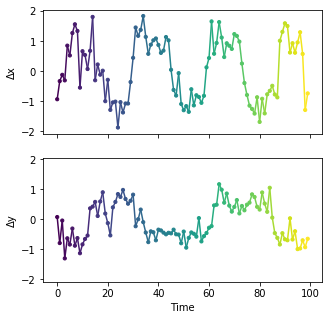

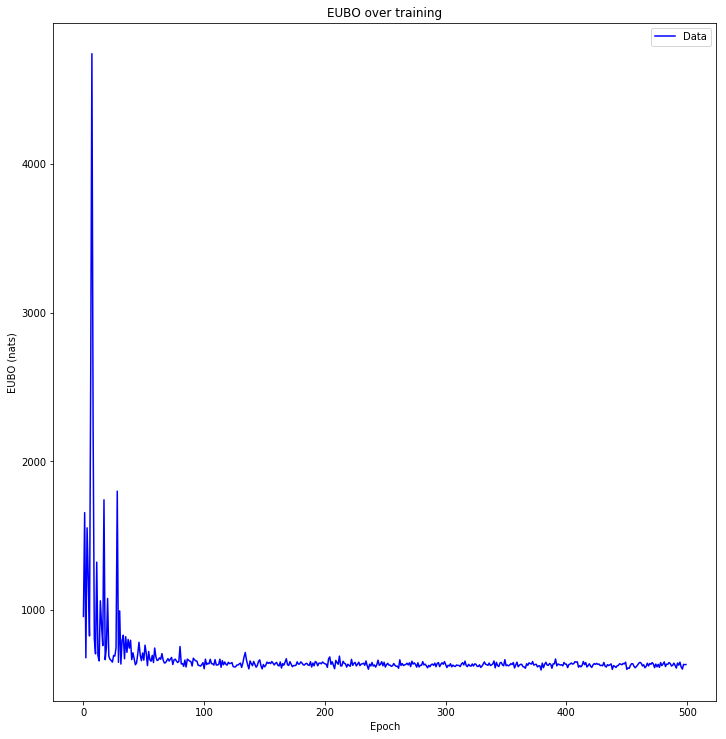

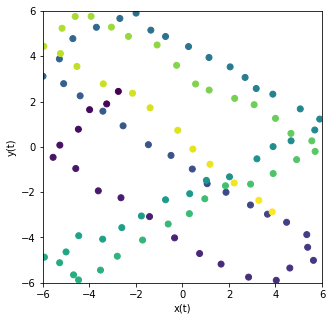

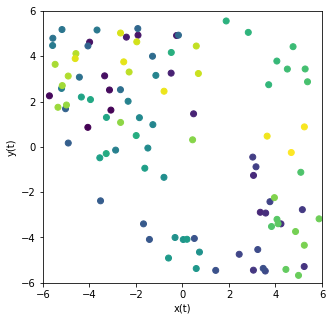

03/04/2019 14:04:17 MSE at time 0: tensor(4.2449)
03/04/2019 14:04:17 MSE at time 1: tensor(0.1079)
03/04/2019 14:04:17 MSE at time 2: tensor(3.3615)
03/04/2019 14:04:17 MSE at time 3: tensor(4.7937)
03/04/2019 14:04:17 MSE at time 4: tensor(13.0722)
03/04/2019 14:04:17 MSE at time 5: tensor(28.3164)
03/04/2019 14:04:17 MSE at time 6: tensor(41.8178)
03/04/2019 14:04:17 MSE at time 7: tensor(58.3373)
03/04/2019 14:04:17 MSE at time 8: tensor(50.3228)
03/04/2019 14:04:17 MSE at time 9: tensor(40.9815)
03/04/2019 14:04:17 MSE at time 10: tensor(30.6676)
03/04/2019 14:04:17 MSE at time 11: tensor(10.1351)
03/04/2019 14:04:17 MSE at time 12: tensor(17.2789)
03/04/2019 14:04:17 MSE at time 13: tensor(8.5434)
03/04/2019 14:04:17 MSE at time 14: tensor(6.2519)
03/04/2019 14:04:17 MSE at time 15: tensor(0.3870)
03/04/2019 14:04:17 MSE at time 16: tensor(6.8538)
03/04/2019 14:04:17 MSE at time 17: tensor(2.8134)
03/04/2019 14:04:17 MSE at time 18: tensor(17.1121)
03/04/2019 14:04:17 MSE at time

Epoch   324: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 14:06:05 EUBO=2.52351593e+02 at epoch 326
03/04/2019 14:06:05 EUBO=2.48981369e+02 at epoch 327
03/04/2019 14:06:06 EUBO=2.37891205e+02 at epoch 328
03/04/2019 14:06:06 EUBO=2.25004608e+02 at epoch 329
03/04/2019 14:06:06 EUBO=2.34588593e+02 at epoch 330
03/04/2019 14:06:07 EUBO=2.23018463e+02 at epoch 331
03/04/2019 14:06:07 EUBO=2.35638824e+02 at epoch 332
03/04/2019 14:06:08 EUBO=2.45204559e+02 at epoch 333
03/04/2019 14:06:08 EUBO=2.17375275e+02 at epoch 334
03/04/2019 14:06:08 EUBO=2.63408905e+02 at epoch 335
03/04/2019 14:06:09 EUBO=2.29294647e+02 at epoch 336
03/04/2019 14:06:09 EUBO=2.43834076e+02 at epoch 337
03/04/2019 14:06:09 EUBO=2.24566376e+02 at epoch 338
03/04/2019 14:06:10 EUBO=2.54119720e+02 at epoch 339
03/04/2019 14:06:10 EUBO=2.38941986e+02 at epoch 340
03/04/2019 14:06:11 EUBO=2.36955231e+02 at epoch 341
03/04/2019 14:06:11 EUBO=2.31541107e+02 at epoch 342
03/04/2019 14:06:11 EUBO=2.47526535e+02 at epoch 343
03/04/2019 14:06:12 EUBO=2.24065216e+02 at epo

Epoch   425: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 14:06:37 EUBO=2.44590118e+02 at epoch 428
03/04/2019 14:06:37 EUBO=2.31891571e+02 at epoch 429
03/04/2019 14:06:37 EUBO=2.50007248e+02 at epoch 430
03/04/2019 14:06:37 EUBO=2.18057587e+02 at epoch 431
03/04/2019 14:06:38 EUBO=2.46212921e+02 at epoch 432
03/04/2019 14:06:38 EUBO=2.41689240e+02 at epoch 433
03/04/2019 14:06:38 EUBO=2.32651459e+02 at epoch 434
03/04/2019 14:06:38 EUBO=1.94730087e+02 at epoch 435
03/04/2019 14:06:39 EUBO=2.45400970e+02 at epoch 436
03/04/2019 14:06:39 EUBO=2.74718781e+02 at epoch 437
03/04/2019 14:06:39 EUBO=2.50192902e+02 at epoch 438
03/04/2019 14:06:40 EUBO=2.26820587e+02 at epoch 439
03/04/2019 14:06:40 EUBO=2.20567841e+02 at epoch 440
03/04/2019 14:06:40 EUBO=2.49824799e+02 at epoch 441
03/04/2019 14:06:40 EUBO=2.24517487e+02 at epoch 442
03/04/2019 14:06:41 EUBO=2.45098358e+02 at epoch 443
03/04/2019 14:06:41 EUBO=1.86787811e+02 at epoch 444
03/04/2019 14:06:41 EUBO=2.50114914e+02 at epoch 445
03/04/2019 14:06:41 EUBO=2.19518463e+02 at epo

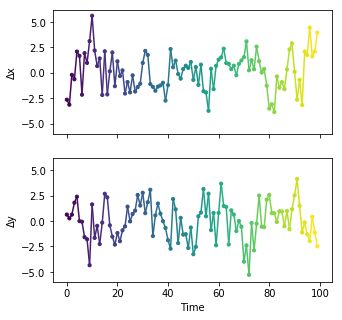

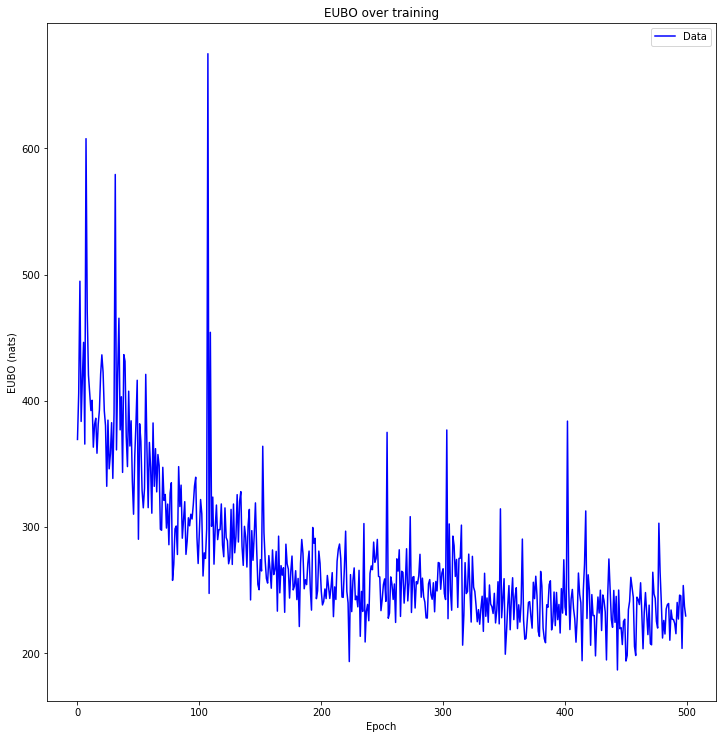

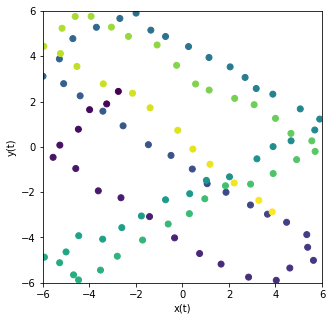

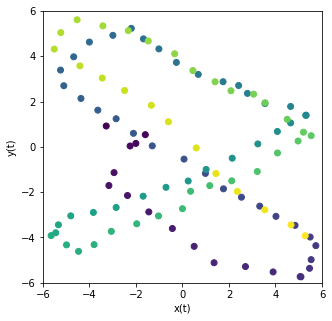

03/04/2019 14:06:56 MSE at time 0: tensor(2.6099)
03/04/2019 14:06:56 MSE at time 1: tensor(4.6058)
03/04/2019 14:06:56 MSE at time 2: tensor(6.1760)
03/04/2019 14:06:56 MSE at time 3: tensor(5.4948)
03/04/2019 14:06:56 MSE at time 4: tensor(6.9084)
03/04/2019 14:06:56 MSE at time 5: tensor(7.3117)
03/04/2019 14:06:56 MSE at time 6: tensor(6.3714)
03/04/2019 14:06:56 MSE at time 7: tensor(5.5836)
03/04/2019 14:06:56 MSE at time 8: tensor(6.7320)
03/04/2019 14:06:56 MSE at time 9: tensor(5.4076)
03/04/2019 14:06:56 MSE at time 10: tensor(4.0896)
03/04/2019 14:06:56 MSE at time 11: tensor(4.2230)
03/04/2019 14:06:56 MSE at time 12: tensor(5.1267)
03/04/2019 14:06:56 MSE at time 13: tensor(4.9206)
03/04/2019 14:06:56 MSE at time 14: tensor(1.1526)
03/04/2019 14:06:56 MSE at time 15: tensor(0.7205)
03/04/2019 14:06:56 MSE at time 16: tensor(0.0109)
03/04/2019 14:06:56 MSE at time 17: tensor(0.1297)
03/04/2019 14:06:56 MSE at time 18: tensor(0.0324)
03/04/2019 14:06:56 MSE at time 19: tenso

Epoch   217: reducing learning rate of group 0 to 5.0000e-02.


03/04/2019 14:08:10 EUBO=4.00455750e+02 at epoch 219
03/04/2019 14:08:10 EUBO=3.88542145e+02 at epoch 220
03/04/2019 14:08:10 EUBO=3.69246643e+02 at epoch 221
03/04/2019 14:08:11 EUBO=2.63988312e+02 at epoch 222
03/04/2019 14:08:11 EUBO=3.15165253e+02 at epoch 223
03/04/2019 14:08:11 EUBO=3.22445190e+02 at epoch 224
03/04/2019 14:08:11 EUBO=3.13243683e+02 at epoch 225
03/04/2019 14:08:12 EUBO=3.36242706e+02 at epoch 226
03/04/2019 14:08:12 EUBO=2.42727676e+02 at epoch 227
03/04/2019 14:08:12 EUBO=4.83112152e+02 at epoch 228
03/04/2019 14:08:13 EUBO=2.36833969e+02 at epoch 229
03/04/2019 14:08:13 EUBO=3.27435394e+02 at epoch 230
03/04/2019 14:08:13 EUBO=3.21134308e+02 at epoch 231
03/04/2019 14:08:14 EUBO=4.02759033e+02 at epoch 232
03/04/2019 14:08:14 EUBO=3.70559418e+02 at epoch 233
03/04/2019 14:08:14 EUBO=4.68672699e+02 at epoch 234
03/04/2019 14:08:15 EUBO=2.75001770e+02 at epoch 235
03/04/2019 14:08:15 EUBO=4.75244446e+02 at epoch 236
03/04/2019 14:08:15 EUBO=3.29413452e+02 at epo

Epoch   318: reducing learning rate of group 0 to 2.5000e-02.


03/04/2019 14:08:41 EUBO=4.03965576e+02 at epoch 320
03/04/2019 14:08:42 EUBO=2.92816345e+02 at epoch 321
03/04/2019 14:08:42 EUBO=2.85751312e+02 at epoch 322
03/04/2019 14:08:42 EUBO=3.88811676e+02 at epoch 323
03/04/2019 14:08:43 EUBO=3.06560089e+02 at epoch 324
03/04/2019 14:08:43 EUBO=4.01972687e+02 at epoch 325
03/04/2019 14:08:43 EUBO=2.05905151e+02 at epoch 326
03/04/2019 14:08:43 EUBO=3.95998596e+02 at epoch 327
03/04/2019 14:08:44 EUBO=3.10090637e+02 at epoch 328
03/04/2019 14:08:44 EUBO=4.14065979e+02 at epoch 329
03/04/2019 14:08:44 EUBO=3.31400574e+02 at epoch 330
03/04/2019 14:08:45 EUBO=2.85575714e+02 at epoch 331
03/04/2019 14:08:45 EUBO=4.10210541e+02 at epoch 332
03/04/2019 14:08:45 EUBO=3.20420380e+02 at epoch 333
03/04/2019 14:08:46 EUBO=4.70864502e+02 at epoch 334
03/04/2019 14:08:46 EUBO=3.39550262e+02 at epoch 335
03/04/2019 14:08:46 EUBO=4.63240509e+02 at epoch 336
03/04/2019 14:08:47 EUBO=4.03335205e+02 at epoch 337
03/04/2019 14:08:47 EUBO=4.84972290e+02 at epo

Epoch   419: reducing learning rate of group 0 to 1.2500e-02.


03/04/2019 14:09:13 EUBO=4.06321106e+02 at epoch 421
03/04/2019 14:09:13 EUBO=3.05388672e+02 at epoch 422
03/04/2019 14:09:13 EUBO=3.64687653e+02 at epoch 423
03/04/2019 14:09:14 EUBO=3.84897614e+02 at epoch 424
03/04/2019 14:09:14 EUBO=2.42256973e+02 at epoch 425
03/04/2019 14:09:14 EUBO=4.54157471e+02 at epoch 426
03/04/2019 14:09:14 EUBO=3.55470581e+02 at epoch 427
03/04/2019 14:09:15 EUBO=3.41981873e+02 at epoch 428
03/04/2019 14:09:15 EUBO=2.87360168e+02 at epoch 429
03/04/2019 14:09:15 EUBO=4.00269684e+02 at epoch 430
03/04/2019 14:09:16 EUBO=5.31320435e+02 at epoch 431
03/04/2019 14:09:16 EUBO=3.30439484e+02 at epoch 432
03/04/2019 14:09:16 EUBO=3.48928955e+02 at epoch 433
03/04/2019 14:09:17 EUBO=2.75328583e+02 at epoch 434
03/04/2019 14:09:17 EUBO=4.18408905e+02 at epoch 435
03/04/2019 14:09:17 EUBO=3.37172668e+02 at epoch 436
03/04/2019 14:09:17 EUBO=2.78362122e+02 at epoch 437
03/04/2019 14:09:18 EUBO=3.78742340e+02 at epoch 438
03/04/2019 14:09:18 EUBO=4.15682373e+02 at epo

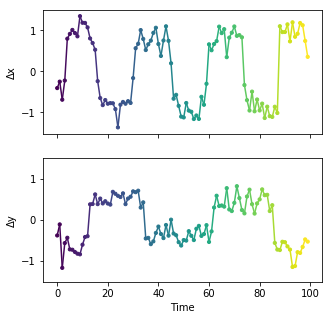

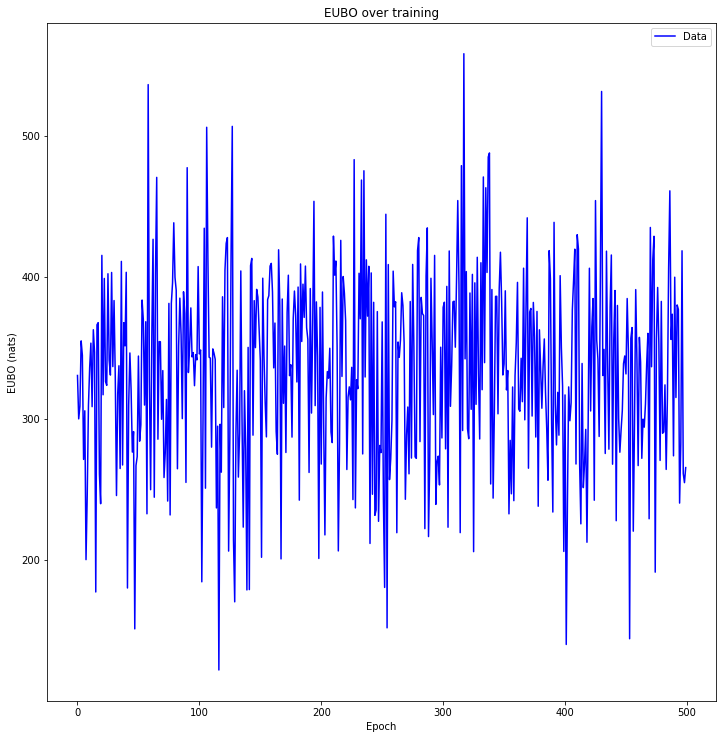

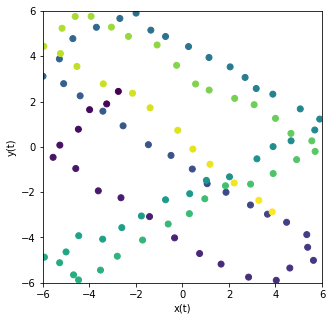

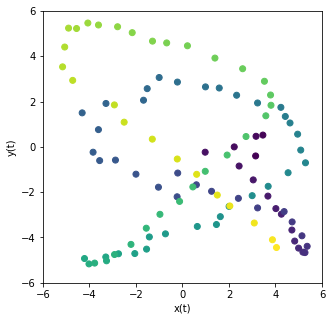

03/04/2019 14:09:37 MSE at time 0: tensor(42.9885)
03/04/2019 14:09:37 MSE at time 1: tensor(47.0255)
03/04/2019 14:09:37 MSE at time 2: tensor(52.6168)
03/04/2019 14:09:37 MSE at time 3: tensor(45.5518)
03/04/2019 14:09:37 MSE at time 4: tensor(39.1713)
03/04/2019 14:09:37 MSE at time 5: tensor(64.1523)
03/04/2019 14:09:37 MSE at time 6: tensor(58.5109)
03/04/2019 14:09:37 MSE at time 7: tensor(53.2686)
03/04/2019 14:09:37 MSE at time 8: tensor(44.6168)
03/04/2019 14:09:37 MSE at time 9: tensor(32.1696)
03/04/2019 14:09:37 MSE at time 10: tensor(25.5771)
03/04/2019 14:09:37 MSE at time 11: tensor(17.0353)
03/04/2019 14:09:37 MSE at time 12: tensor(11.6142)
03/04/2019 14:09:37 MSE at time 13: tensor(6.6738)
03/04/2019 14:09:37 MSE at time 14: tensor(3.0244)
03/04/2019 14:09:37 MSE at time 15: tensor(1.4772)
03/04/2019 14:09:37 MSE at time 16: tensor(1.4184)
03/04/2019 14:09:37 MSE at time 17: tensor(1.6988)
03/04/2019 14:09:37 MSE at time 18: tensor(1.9833)
03/04/2019 14:09:37 MSE at t

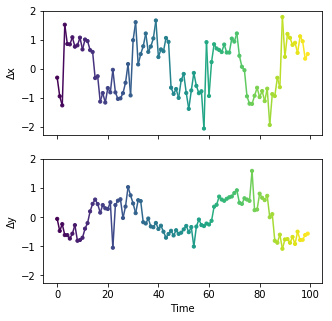

In [24]:
results_dict = experiment()

In [25]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')